# **Dock-MD-FEP**

---
Docking, Molecular dynamic(MD), and Free energy perturbation (FEP) are important modelling methods in medicinal chemistry.

This Jupyter notebook shows how to run a Three-in-one simulation, i.e., docking, MD and FEP, with freely available GPU(and CPU) from Google Colab.

---

 **This notebook has NOT been thoroughly tested and validated. Use it at your own risk!** 

--- 

**This notebook is based on**
- The MD simulation is based on [OpenMM](https://openmm.org/) and [Making-it-rain](https://twitter.com/pablitoarantes)

- The FEP simulation is based on [Yank](http://getyank.org/latest/)

- The docking is based on [Smina](https://sourceforge.net/projects/smina/)


- Other open-soured packages like [Open-Sourced-PyMOL](https://anaconda.org/conda-forge/pymol-open-source)/  [OpenBabel](https://github.com/openbabel/openbabel)/ [Rdkit](https://github.com/rdkit/rdkit) etc.

- Also, some github example/tutorial repositories,  [Yank example](https://github.com/choderalab/yank-examples) and [A customized yank script](https://github.com/quantaosun/OpenMM-Yank-YAML-template)




## **Install dependencies, you only need to install this once**
IMPOTANT: Run these commands from the command line within the conda env with python 3.8 
```
#import sys
!pip -q install py3Dmol 2>&1 1>/dev/null
!pip install --upgrade MDAnalysis 2>&1 1>/dev/null
!pip install git+https://github.com/pablo-arantes/biopandas 2>&1 1>/dev/null
!pip install rdkit-pypi
!pip install Cython
!git clone https://github.com/pablo-arantes/ProLIF.git
prolif1 = "cd /content/ProLIF"
prolif2 = "sed -i 's/mdanalysis.*/mdanalysis==2.0.0/' setup.cfg"
prolif3 = "pip install ."

original_stdout = sys.stdout # Save a reference to the original standard output

with open('prolif.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(prolif1)
    print(prolif2)
    print(prolif3)
    sys.stdout = original_stdout # Reset the standard output to its original value

!chmod 700 prolif.sh 2>&1 1>/dev/null
!bash prolif.sh >/dev/null 2>&1

# install conda
#!wget -qnc https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh 
#!bash Miniconda3-latest-Linux-x86_64.sh -bfp /usr/local 2>&1 1>/dev/null
#!rm -r Miniconda3-latest-Linux-x86_64.sh /content/ProLIF prolif.sh
!conda install -y -q -c conda-forge openmm=7.6 python=3.8 pdbfixer 2>&1 1>/dev/null
!conda install -c conda-forge openbabel --yes 2>&1 1>/dev/null
!conda install -c conda-forge ambertools --yes 2>&1 1>/dev/null
!conda install -c conda-forge parmed  --yes 2>&1 1>/dev/null
!conda install -c conda-forge openff-toolkit --yes 
!conda install -c conda-forge pymol-open-source --yes # This is only in the local version
!conda install -c conda-forge progressbar --yes # This is only in the local version for SDF conf generation before docking.
```

In [2]:

import sys

#load dependencies
sys.path.append('/home/qq/anaconda3/envs/Dock-MD-FEP/lib/python3.8/site-packages')
from openmm import app, unit
from openmm.app import HBonds, NoCutoff, PDBFile
from openff.toolkit.topology import Molecule, Topology
from openff.toolkit.typing.engines.smirnoff import ForceField
from openff.toolkit.utils import get_data_file_path
import parmed as pmd
from biopandas.pdb import PandasPdb
import openmm as mm
from openmm import *
from openmm.app import *
from openmm.unit import *
import os
import urllib.request  
import numpy as np
import MDAnalysis as mda
import py3Dmol
import pytraj as pt
import platform
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata
import seaborn as sb
from statistics import mean, stdev
from pytraj import matrix
from matplotlib import colors
from IPython.display import set_matplotlib_formats
#!wget  https://raw.githubusercontent.com/openforcefield/openff-forcefields/master/openforcefields/offxml/openff_unconstrained-2.0.0.offxml 2>&1 1>/dev/null
#!wget --no-check-certificate https://sourceforge.net/projects/smina/files/smina.static/download -O smina.static
#!chmod u+x smina.static
#@title Install Pymol
#!apt-get install pymol 2>&1 1>/dev/null

RuntimeError: module compiled against API version 0x10 but this version of numpy is 0xf . Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem .

# Input

In [1]:
#@title Input expected from the user
path = "." #@param {type:"string"}
%cd '{path}'
PDB_ID = "3HTB" #@param {type:"string"}
pdb = PDB_ID + ".pdb"
! wget https://files.rcsb.org/download/$pdb
#@title Ligand three-letter name
Ligand = "JZ4" #@param {type:"string"}
smiles = "c1ccccc1" #@param {type:"string"}


/home/qq/Desktop/Dock-MD-FEP
--2022-12-25 11:11:59--  https://files.rcsb.org/download/3HTB.pdb
Resolving files.rcsb.org (files.rcsb.org)... 132.249.210.134
Connecting to files.rcsb.org (files.rcsb.org)|132.249.210.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: '3HTB.pdb’

3HTB.pdb                [  <=>               ] 161.13K   276KB/s    in 0.6s    

2022-12-25 11:12:01 (276 KB/s) - '3HTB.pdb’ saved [164997]



In [3]:
#@title Loading packages
import sys
from collections import defaultdict
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools
import pandas as pd

%pylab inline
IPythonConsole.ipython_3d = True

import py3Dmol
import matplotlib.pyplot as plt
import subprocess

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/qq/anaconda3/envs/Dock-MD-FEP/lib/python3.8/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['bar', 'norm', 'tan', 'sinh', 'cos', 'cosh', 'radians', 'sin', 'byte', 'dot', 'sqrt', 'copy', 'degrees', 'tanh', 'sum', 'bytes']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

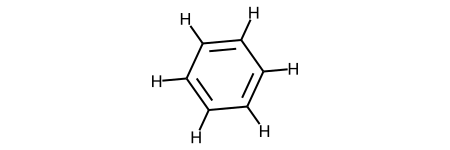

In [4]:
#@title Visualizatino of small molecule to be docked
mol = Chem.MolFromSmiles(smiles) 
mol = Chem.AddHs(mol)
AllChem.EmbedMolecule(mol)
AllChem.MMFFOptimizeMolecule(mol)
mol

# Process PDB strcture (Stage 0)

In [5]:
#@title Write out a script for pymol
com_file = open('split.pml','w')
com_file.write('''
load 3HTB.pdb
remove resn HOH
h_add elem O or elem N
select 3HTB-JZ4, resn JZ4 #Create a selection called 1OYT-FSN from the ligand
select 3HTB-receptor, 3HTB and not 3HTB-JZ4 #Select all that is not the ligand
save 3HTB-JZ4.pdb, 3HTB-JZ4
save 3HTB-receptor.pdb, 3HTB-receptor    
''')
com_file.close()

In [6]:
#@title Correct the script with right PDB ID and ligand name
!sed -i 's/3HTB/{PDB_ID}/g' split.pml
!sed 's/JZ4/{Ligand}/g' split.pml
!sed -i 's/JZ4/{Ligand}/g' split.pml


load 3HTB.pdb
remove resn HOH
h_add elem O or elem N
select 3HTB-JZ4, resn JZ4 #Create a selection called 1OYT-FSN from the ligand
select 3HTB-receptor, 3HTB and not 3HTB-JZ4 #Select all that is not the ligand
save 3HTB-JZ4.pdb, 3HTB-JZ4
save 3HTB-receptor.pdb, 3HTB-receptor    


In [7]:
#@title Run pymol
%cd '{path}'
! pymol -c split.pml

/home/qq/Desktop/Dock-MD-FEP
 PyMOL(TM) Molecular Graphics System, Version 2.5.0.
 Copyright (c) Schrodinger, LLC.
 All Rights Reserved.
 
    Created by Warren L. DeLano, Ph.D. 
 
    PyMOL is user-supported open-source software.  Although some versions
    are freely available, PyMOL is not in the public domain.
 
    If PyMOL is helpful in your work or study, then please volunteer 
    support for our ongoing efforts to create open and affordable scientific
    software by purchasing a PyMOL Maintenance and/or Support subscription.

    More information can be found at "http://www.pymol.org".
 
    Enter "help" for a list of commands.
    Enter "help <command-name>" for information on a specific command.

 Hit ESC anytime to toggle between text and graphics.

 Detected 16 CPU cores.  Enabled multithreaded rendering.
PyMOL>load 3HTB.pdb
HEADER    HYDROLASE                               11-JUN-09   3HTB
TITLE     2-PROPYLPHENOL IN COMPLEX WITH T4 LYSOZYME L99A/M102Q
COMPND    MOL_ID: 

In [8]:
#@title Allocate two variable needed for MD
# PFB_ID = input by user
# Ligand = input by user
Protein_PDB_file_name = PDB_ID + '-receptor.pdb'
ligand_name = PDB_ID + '-' + Ligand + '.pdb'

# PDB structure optimisation before docking (Stage 0)

---
---
## **Loading the necessary input files**

At this point, we should have all libraries and dependencies installed and all necessary input files already at your Google Drive folder.

**Important**: Make sure the PDB file points to the correct pathway. This path is what you have input previously.




In [9]:
#@title **Loading input for MD automaticlly**: 

#%%capture
import rdkit
import mdtraj as md
from rdkit import Chem
from rdkit.Chem import AllChem,Draw
from rdkit.Chem.Draw import IPythonConsole
from pdbfixer import PDBFixer
from openbabel import pybel

#Protein_PDB_file_name = '3HTB-receptor.pdb' #@param {type:"string"}
#Ligand_PDB_file_name = '3HTB-JZ4.pdb'  #@param {type:"string"}

Add_ligand_hydrogens = "Yes" 


#ligand_name = Ligand_PDB_file_name
Google_Drive_Path = path
workDir = Google_Drive_Path
file_name = os.path.join(workDir, str(Protein_PDB_file_name)) 
initial_pdb = os.path.join(workDir, "starting0.pdb")
ligand_pdb = os.path.join(workDir, str(ligand_name))
ligand_pdb2 = os.path.join(workDir, "ligand_H.pdb")
starting = os.path.join(workDir, "starting1.pdb")
starting2 = os.path.join(workDir, "starting2.pdb")
starting_end = os.path.join(workDir, "starting_end.pdb")

#Add hydrogens in the ligand
if Add_ligand_hydrogens == "Yes":
  fixer = PDBFixer(filename=ligand_pdb)
  PDBFile.writeFile(fixer.topology, fixer.positions, open("temp.pdb", 'w'))
  
  ppdb = PandasPdb().read_pdb("temp.pdb")
  ppdb.df['ATOM'] = ppdb.df['ATOM']
  ppdb.df['HETATM']= ppdb.df['HETATM'][ppdb.df['HETATM']['element_symbol'] != 'H']
  ppdb.to_pdb(path="temp.pdb", records=['ATOM', 'HETATM'], gz=False, append_newline=True)

  mol= [m for m in pybel.readfile(filename="temp.pdb", format='pdb')][0]
  mol.calccharges
  mol.addh()
  out=pybel.Outputfile(filename="temp2.pdb",format='pdb',overwrite=True)
  out.write(mol)
  out.close()

  md.load("temp2.pdb").save("temp2.pdb")
    
  halogens = ['Cl', 'F', 'Br', 'I']
  atom_id = []
  H_id = []
  with open("temp2.pdb") as f:
      for line in f:
        data = line.split()
        if data[0] == "ATOM":
          if data[2] in halogens:
            atom_id.append(data[1])
        if data[0] == "CONECT":
          if data[1] in atom_id:
            if len(data) > 3:
              H_id.append(data[3])
              H_id.append(data[4])
              H_id.append(data[5])

  with open(ligand_pdb2, 'w') as h:
    with open("temp2.pdb") as f:
      for line in f:
        data = line.split()
        if data[0] == "ATOM":
          if data[1] not in H_id:
            print(line, file=h)
        elif data[0] == "CONECT":
            if data[1] not in atom_id:
              print(line, file=h)
        else:
          print(line, file=h)

  fixer = PDBFixer(filename=ligand_pdb2)
  PDBFile.writeFile(fixer.topology, fixer.positions, open(ligand_pdb2, 'w'))

else:
  fixer = PDBFixer(filename=ligand_pdb)
  PDBFile.writeFile(fixer.topology, fixer.positions, open(ligand_pdb2, 'w'))

#Fix protein
pdb_parm = pmd.load_file(file_name)
pdb_parm.save(initial_pdb, standard_resnames=True, overwrite=True)

ppdb = PandasPdb().read_pdb(initial_pdb)
ppdb.df['ATOM'] = ppdb.df['ATOM']
ppdb.df['HETATM'] = ppdb.df['HETATM'][ppdb.df['HETATM']['residue_name'] == 'HOH']
ppdb.df['ATOM'] = ppdb.df['ATOM'][ppdb.df['ATOM']['atom_name'] != 'OXT']
ppdb.df['ATOM']= ppdb.df['ATOM'][ppdb.df['ATOM']['element_symbol'] != 'H']
ppdb.to_pdb(path=starting, records=['ATOM', 'HETATM'], gz=False, append_newline=True)

from Bio.PDB import is_aa
from Bio.PDB import PDBParser, PDBIO, Select


class ProtSelect(Select):
    def accept_residue(self, residue):
        print(f"{residue} -> {is_aa(residue)}")
        return is_aa(residue, standard=True)


from Bio import PDB

pdb_ini = PDBParser().get_structure("pdb", starting)
io = PDBIO()
io.set_structure(pdb_ini)
io.save(starting2, ProtSelect());

pdb4amber_cmd = "pdb4amber -i " + str(starting2) + " -o " + str(starting_end) + " -p"
original_stdout = sys.stdout # Save a reference to the original standard output

with open('pdb4amber.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(pdb4amber_cmd)
    sys.stdout = original_stdout # Reset the standard output to its original value

!chmod 700 pdb4amber.sh 2>&1 1>/dev/null
!bash pdb4amber.sh 2> /dev/null

!rm pdb4amber.sh temp.pdb temp2.pdb

#@markdown ---

/home/qq/anaconda3/envs/Dock-MD-FEP/lib/python3.8/site-packages/openmm/app/internal/pdbstructure.py:537: UserWarning: WARNING: duplicate atom (ATOM     12  H   JZ4 A   1      25.313 -24.362   0.151  1.00  0.00           H  , ATOM     11  H   JZ4 A   1      23.739 -23.212  -5.158  1.00  0.00           H  )
  warnings.warn("WARNING: duplicate atom (%s, %s)" % (atom, old_atom._pdb_string(old_atom.serial_number, atom.alternate_location_indicator)))
/home/qq/anaconda3/envs/Dock-MD-FEP/lib/python3.8/site-packages/openmm/app/internal/pdbstructure.py:537: UserWarning: WARNING: duplicate atom (ATOM     13  H   JZ4 A   1      23.659 -24.533   0.687  1.00  0.00           H  , ATOM     12  H   JZ4 A   1      25.313 -24.362   0.151  1.00  0.00           H  )
  warnings.warn("WARNING: duplicate atom (%s, %s)" % (atom, old_atom._pdb_string(old_atom.serial_number, atom.alternate_location_indicator)))
/home/qq/anaconda3/envs/Dock-MD-FEP/lib/python3.8/site-packages/openmm/app/internal/pdbstructure.py:53

<Residue MET het=  resseq=1 icode= > -> True
<Residue ASN het=  resseq=2 icode= > -> True
<Residue ILE het=  resseq=3 icode= > -> True
<Residue PHE het=  resseq=4 icode= > -> True
<Residue GLU het=  resseq=5 icode= > -> True
<Residue MET het=  resseq=6 icode= > -> True
<Residue LEU het=  resseq=7 icode= > -> True
<Residue ARG het=  resseq=8 icode= > -> True
<Residue ILE het=  resseq=9 icode= > -> True
<Residue ASP het=  resseq=10 icode= > -> True
<Residue GLU het=  resseq=11 icode= > -> True
<Residue GLY het=  resseq=12 icode= > -> True
<Residue LEU het=  resseq=13 icode= > -> True
<Residue ARG het=  resseq=14 icode= > -> True
<Residue LEU het=  resseq=15 icode= > -> True
<Residue LYS het=  resseq=16 icode= > -> True
<Residue ILE het=  resseq=17 icode= > -> True
<Residue TYR het=  resseq=18 icode= > -> True
<Residue LYS het=  resseq=19 icode= > -> True
<Residue ASP het=  resseq=20 icode= > -> True
<Residue THR het=  resseq=21 icode= > -> True
<Residue GLU het=  resseq=22 icode= > -> Tr

No chiral centres were identified! 
Isomer 1 = Oc1ccccc1CCC


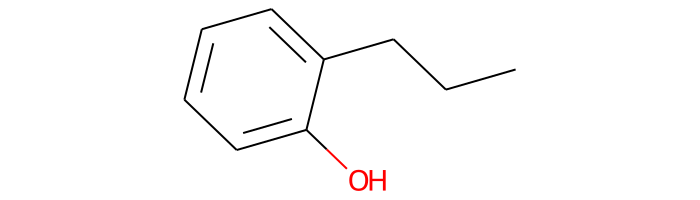

In [10]:
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem,Draw
from rdkit.Chem.Draw import IPythonConsole

#@title **Enumerate Stereoisomers to generate ligand topology:**

##@markdown **You can find the smiles for your lingad at: https://pubchem.ncbi.nlm.nih.gov/**

mol= [m for m in pybel.readfile(filename=ligand_pdb2, format='pdb')][0]
mol.calccharges
mol.addh()
out=pybel.Outputfile(filename="temp2.smi",format='smiles',overwrite=True)
out.write(mol)
out.close()

fileObj = open("temp2.smi", "r",) #opens the file in read mode
for aRow in fileObj:
    smi = aRow.split('\t')
fileObj.close()

Ligand_smiles = smi[0] 
!rm temp2.smi >/dev/null 2>&1

mol = Chem.MolFromSmiles(Ligand_smiles)

def spam(n):
    out=[]
    for perm in getPerms(n):
        elem = [ int(i) for i in list(perm) ]
        out.append(elem)
    return out

def getPerms(n):
    from itertools import permutations
    for i in getCandidates(n):
        for perm in set(permutations(i)):
            yield ''.join(perm)

def getCandidates(n):
    for i in range(0, n+1):
        res = "1" * i + "0" * (n - i)
        yield res

def GetStereoIsomers(mol):
    from rdkit import Chem
    from copy import copy
    out = []   

    chiralCentres = Chem.FindMolChiralCenters(mol, includeUnassigned=True)

    #return the molecule object when no chiral centres where identified
    if chiralCentres == []:
        return [mol]

      #All bit permutations with number of bits equals number of chiralCentres
    elements = spam(len(chiralCentres))
    !rm smiles.txt temp2.smi >/dev/null 2>&1
    for isoId,element in enumerate(elements):       
        for centreId,i in enumerate(element):
            atomId = chiralCentres[centreId][0]
            if i == 0:
                mol.GetAtomWithIdx(atomId).SetChiralTag(Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW)
            elif i == 1:
                mol.GetAtomWithIdx(atomId).SetChiralTag(Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW)
        outmol = copy(mol)
        out.append(outmol)
        print(Chem.MolToSmiles(mol,isomericSmiles=True), file=open("smiles.txt", "a",))
    return out

Draw.MolsToGridImage(GetStereoIsomers(mol), subImgSize=(500,200), molsPerRow=1)
chiralCentres = Chem.FindMolChiralCenters(mol, includeUnassigned=True)
if chiralCentres != []:
  print("Follow the stereoisomers for your ligand: \n")
  fileObj = open("smiles.txt", "r",) #opens the file in read mode
  smiles = fileObj.read().splitlines() #puts the file into an array
  fileObj.close()
  x = len(smiles[:-1])
  for a in range(x+1):
    y = smiles[0+a:(a+1)]
    globals()[f"isomer{a+1}"] = str(y[0])
    print("Isomer " + str(a+1) + " = " + str(y[0]) + "\n")
else:
  isomer1 = Ligand_smiles
  print("No chiral centres were identified! \nIsomer 1 = " + str(isomer1)  )
Draw.MolsToGridImage(GetStereoIsomers(mol), subImgSize=(700,200), molsPerRow=1, returnPNG=True)

In [11]:
from rdkit import Chem
from rdkit.Chem import PandasTools
from openff.toolkit.typing.engines.smirnoff import ForceField
import parmed

#@title **Parameters to generate the topology:**

#@markdown **Parameters to generate the protein topology:**

Force_field = "ff19SB" #@param ["ff19SB", "ff14SB"]
if Force_field == "ff19SB":
  ff = "leaprc.protein.ff19SB"
else:
  ff = "leaprc.protein.ff14SB"

Water_type = "TIP3P" #@param ["TIP3P", "OPC"]
if Water_type == "TIP3P":
  water = "leaprc.water.tip3p"
  water_box = "TIP3PBOX"
else:
  water = "leaprc.water.opc"
  water_box = "OPCBOX"

#@markdown Size Box (Angstrons):

Size_box = 12 #@param {type:"slider", min:10, max:20, step:1}
size_box = Size_box

#@markdown **ATTENTION**: Give the concentration in Molar units, AMBER tleap will neutralize your system automatically:

Ions = "NaCl" #@param ["NaCl", "KCl" ]

Concentration = "0.15" #@param {type:"string"}

#@markdown **Parameters to generate the ligand topology:**

Ligand_Force_field = "GAFF2" #@param ["GAFF2", "OpenFF 2.0.0 (Sage)"]

Ligand_isomer = "1" #@param {type:"string", min:1, max:10, step:100}
if chiralCentres == []:
  isomer_end = isomer1
else:
  isomer_end = globals()[f"isomer{Ligand_isomer}"]

Ligand_net_charges = "0" #@param {type:"string", min:-10, max:10, step:1}

#@markdown ---
tleap = os.path.join(workDir, "tleap.in")
top_nw = os.path.join(workDir, "SYS_nw.prmtop")
crd_nw = os.path.join(workDir, "SYS_nw.crd")
pdb_nw = os.path.join(workDir, "SYS_nw.pdb")
top = os.path.join(workDir, "SYS_gaff2.prmtop")
crd = os.path.join(workDir, "SYS_gaff2.crd")
pdb = os.path.join(workDir, "SYS.pdb")
ligand_noh = os.path.join(workDir, "ligand_noh.pdb")
ligand_h = os.path.join(workDir, "ligand_h.pdb")
ligand_mol2 = os.path.join(workDir, "ligand.mol2")
ligand_frcmod = os.path.join(workDir, "ligand.frcmod")
lig_new = os.path.join(workDir, "ligand_gaff.pdb")
protein_ligand = os.path.join(workDir, "protein_ligand.pdb")
lib = os.path.join(workDir, "lig.lib")

#gaff_command1 = "pdb4amber -i " + str(ligand_pdb2) + " -o " + str(ligand_h)
gaff_command1 = "pdb4amber -i " + str(ligand_pdb2) + " -o " + str(ligand_h)
gaff_command3 = "antechamber -i " + str(ligand_h) + " -fi pdb -o " + str(ligand_mol2) + " -fo mol2 -c bcc -nc " + str(Ligand_net_charges) + " -rn LIG -at gaff2"
gaff_command4 = "parmchk2 -i " + str(ligand_mol2) + " -f mol2 -o " + str(ligand_frcmod) + " -s gaff2"

original_stdout = sys.stdout # Save a reference to the original standard output

with open('gaff.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(gaff_command1)
    print(gaff_command3)
    print(gaff_command4)
    sys.stdout = original_stdout # Reset the standard output to its original value

!chmod 700 gaff.sh 2>&1 1>/dev/null
!bash gaff.sh >/dev/null 2>&1

f = open(tleap, "w")
f.write("""source """ + str(ff) + "\n"
"""source leaprc.gaff2
LIG = loadmol2 """ + str(ligand_mol2) + "\n"
"""loadamberparams """ + str(ligand_frcmod) + "\n"
"""saveoff LIG """ + str(lib) + "\n"
"""savepdb LIG """ + str(lig_new) + "\n" 
"""quit""")
f.close()

tleap_command = "tleap -f " + str(tleap)
cat_command = "cat " + str(starting_end) + " " + str(lig_new) + str(" > ") + str(protein_ligand)

original_stdout = sys.stdout # Save a reference to the original standard output

with open('run_tleap.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(tleap_command)
    print(cat_command)
    sys.stdout = original_stdout # Reset the standard output to its original value

!chmod 700 run_tleap.sh 2>&1 1>/dev/null
!bash run_tleap.sh 2>&1 1>/dev/null

ppdb = PandasPdb().read_pdb(protein_ligand)
ppdb.df['ATOM'] = ppdb.df['ATOM']
ppdb.df['OTHERS'] = [ppdb.df['OTHERS'] != 'OTHERS']
ppdb.to_pdb(path=protein_ligand, records=['ATOM', 'HETATM'], gz=False, append_newline=True)

f = open(tleap, "w")
f.write("""source """ + str(ff) + "\n"
"""source leaprc.DNA.OL15
source leaprc.RNA.OL3
source leaprc.GLYCAM_06j-1 
source leaprc.gaff2
source """  + str(water) + "\n"
"""loadamberparams """ + str(ligand_frcmod) + "\n"
"""loadoff """ + str(lib) + "\n" 
"""SYS = loadpdb """ + str(protein_ligand) + "\n"
"""alignaxes SYS
savepdb SYS """ + str(pdb_nw) + "\n"
"""saveamberparm SYS """ + str(top_nw) + " " + str(crd_nw) + "\n"
"""solvatebox SYS """ + str(water_box) + " " + str(size_box) +  """ 0.7
saveamberparm SYS """ + str(top) + " " + str(crd) + "\n"
"""savepdb SYS """ + str(pdb) + "\n"
"""quit""")
f.close()

tleap_command = "tleap -f " + str(tleap)

original_stdout = sys.stdout # Save a reference to the original standard output

with open('run_tleap.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(tleap_command)
    sys.stdout = original_stdout # Reset the standard output to its original value

SYS = os.path.join(workDir, "SYS*")
rm_sys = "rm " + SYS

original_stdout = sys.stdout # Save a reference to the original standard output

with open('rm_sys.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(rm_sys)
    sys.stdout = original_stdout # Reset the standard output to its original value

!chmod 700 rm_sys.sh 2>&1 1>/dev/null
!bash rm_sys.sh 2> /dev/null

!chmod 700 run_tleap.sh 2>&1 1>/dev/null
!bash run_tleap.sh 2>&1 1>/dev/null


!grep "Volume:" leap.log > temp.txt
with open("temp.txt", 'r') as f:
  for line in f:
        vol = float(line.split()[1])

vol_lit  = vol * pow(10, -27)
atom_lit = 9.03 * pow(10, 22)
conc = float(Concentration)
num_ion = int(vol_lit * (conc/0.15) * atom_lit)

if Ions == "NaCl":
  pos_neut = "Na+ 0"
  pos_num = "Na+ " + str(num_ion)
  Cl_num = num_ion
else:
  pos_neut = "K+ 0"
  pos_num = "K+ " + str(num_ion)
  Cl_num = num_ion

f = open(tleap, "w")
f.write("""source """ + str(ff) + "\n"
"""source leaprc.DNA.OL15
source leaprc.RNA.OL3
source leaprc.GLYCAM_06j-1 
source leaprc.gaff2
source """  + str(water) + "\n"
"""loadamberparams """ + str(ligand_frcmod) + "\n"
"""loadoff """ + str(lib) + "\n" 
"""SYS = loadpdb """ + str(protein_ligand) + "\n"
"""alignaxes SYS
check SYS 
charge SYS
addions SYS """ + str(pos_neut) + "\n"
"""addions SYS Cl- 0
check SYS
charge SYS
savepdb SYS """ + str(pdb_nw) + "\n"
"""saveamberparm SYS """ + str(top_nw) + " " + str(crd_nw) + "\n"
"""solvatebox SYS """ + str(water_box) + " " + str(size_box) +  """ 0.7 """ + "\n"
"""addIonsRand SYS """ + str(pos_num) + """ Cl- """ + str(Cl_num) + "\n"
"""saveamberparm SYS """ + str(top) + " " + str(crd) + "\n"
"""savepdb SYS """ + str(pdb) + "\n"
"""quit""")
f.close()


!chmod 700 run_tleap.sh 2>&1 1>/dev/null
!bash run_tleap.sh 2>&1 1>/dev/null

if Ligand_Force_field == "OpenFF 2.0.0 (Sage)":
  mol = Chem.MolFromPDBFile(lig_new, removeHs=False)
  Chem.MolToPDBFile(mol, os.path.join(workDir, "ligand_openFF.pdb"))
  
  in_prmtop = top
  in_crd = crd
  orig_structure = parmed.amber.AmberParm(in_prmtop, in_crd)
  pieces = orig_structure.split()
  for piece in pieces:
      print(f"There are {len(piece[1])} instance(s) of {piece[0]}")

  from openmm.app import PDBFile
  from openff.toolkit.topology import Molecule, Topology
  from openff.toolkit.tests.utils import get_data_file_path

  # rdmol = Chem.MolFromMolFile(os.path.join(workDir, "ligand_openFF.sdf"))
  # ligand_off_molecule = Molecule.from_rdkit(rdmol, hydrogens_are_explicit=True)

  ligand_off_molecule = Molecule.from_smiles(isomer_end)
  ligand_pdbfile = PDBFile(os.path.join(workDir, "ligand_openFF.pdb"))
  ligand_off_topology = Topology.from_openmm(
      ligand_pdbfile.topology,
      unique_molecules=[ligand_off_molecule],)

  force_field = ForceField("openff_unconstrained-2.0.0.offxml")

  ligand_system = force_field.create_openmm_system(ligand_off_topology)
  new_ligand_structure = parmed.openmm.load_topology(
      ligand_off_topology.to_openmm(),
      ligand_system,
      xyz=pieces[1][0].positions,)

  new_ligand_structure.save(os.path.join(workDir, "ligand.prmtop"), overwrite=True)
  new_ligand_structure.save(os.path.join(workDir, "ligand.inpcrd"), overwrite=True)

  # Check how many atoms and which order elements are in the new ligand
  n_atoms_new = len(new_ligand_structure.atoms)
  elements_new = [atom.element for atom in new_ligand_structure.atoms]

  # Check how many atoms and which order elements are in the old ligand
  old_ligand_structure, n_copies = pieces[1]
  n_atoms_old = len(old_ligand_structure.atoms)
  elements_old = [atom.element for atom in old_ligand_structure.atoms]

  print(
      f"There are {n_atoms_old} in the old ligand structure and {n_atoms_new} atoms "
      f"in the new ligand structure")

  # Print out error message if number of atoms doesn't match
  if n_atoms_new != n_atoms_old:
      print(
          "Error: Number of atoms in input ligand doesn't match number extracted "
          "from prmtop file.")

  if elements_new != elements_old:
      print(
          "Error: Elements in input ligand don't match elements in the ligand "
          "from the prmtop file.")
      print(f"Old elements: {elements_old}")
      print(f"New elements: {elements_new}")

  # Create a new, empty system
  complex_structure = parmed.Structure()

  # Add the protein. Convert explicitly to an AmberParm object to ensure that 1-4 scaling factors are preserved.
  complex_structure += parmed.amber.AmberParm.from_structure(pieces[0][0])

  # Add the ligand
  complex_structure += parmed.amber.AmberParm.from_structure(new_ligand_structure)

  # Add ions and Waters
  ppdb = PandasPdb().read_pdb(pdb)
  Cl = [ppdb.df['ATOM']['atom_name'] == 'Cl-']
  Na = [ppdb.df['ATOM']['atom_name'] == 'Na+']
  K = [ppdb.df['ATOM']['atom_name'] == 'K+']
  Cl = np.array(Cl)
  Na = np.array(Na)
  K = np.array(K)

  if True in Cl and True in Na:
    just_ion1_structure = parmed.Structure()
    just_ion1_structure += pieces[2][0]
    just_ion1_structure *= len(pieces[2][1])

    just_ion2_structure = parmed.Structure()
    just_ion2_structure += pieces[3][0]
    just_ion2_structure *= len(pieces[3][1])

    complex_structure += parmed.amber.AmberParm.from_structure(just_ion1_structure)
    complex_structure += parmed.amber.AmberParm.from_structure(just_ion2_structure)

    just_water_structure = parmed.Structure()
    just_water_structure += pieces[4][0]
    just_water_structure *= len(pieces[4][1])

    complex_structure += parmed.amber.AmberParm.from_structure(just_water_structure)
  elif True in Cl and True in K:
    just_ion1_structure = parmed.Structure()
    just_ion1_structure += pieces[2][0]
    just_ion1_structure *= len(pieces[2][1])

    just_ion2_structure = parmed.Structure()
    just_ion2_structure += pieces[3][0]
    just_ion2_structure *= len(pieces[3][1])

    complex_structure += parmed.amber.AmberParm.from_structure(just_ion1_structure)
    complex_structure += parmed.amber.AmberParm.from_structure(just_ion2_structure)

    just_water_structure = parmed.Structure()
    just_water_structure += pieces[4][0]
    just_water_structure *= len(pieces[4][1])

    complex_structure += parmed.amber.AmberParm.from_structure(just_water_structure)
  elif True in Cl:
    just_ion1_structure = parmed.Structure()
    just_ion1_structure += pieces[2][0]
    just_ion1_structure *= len(pieces[2][1])

    complex_structure += parmed.amber.AmberParm.from_structure(just_ion1_structure)

    just_water_structure = parmed.Structure()
    just_water_structure += pieces[3][0]
    just_water_structure *= len(pieces[3][1])

    complex_structure += parmed.amber.AmberParm.from_structure(just_water_structure)
  elif True in Na:
    just_ion1_structure = parmed.Structure()
    just_ion1_structure += pieces[2][0]
    just_ion1_structure *= len(pieces[2][1])

    complex_structure += parmed.amber.AmberParm.from_structure(just_ion1_structure)

    just_water_structure = parmed.Structure()
    just_water_structure += pieces[3][0]
    just_water_structure *= len(pieces[3][1])

    complex_structure += parmed.amber.AmberParm.from_structure(just_water_structure)
  elif True in K:
    just_ion1_structure = parmed.Structure()
    just_ion1_structure += pieces[2][0]
    just_ion1_structure *= len(pieces[2][1])

    complex_structure += parmed.amber.AmberParm.from_structure(just_ion1_structure)

    just_water_structure = parmed.Structure()
    just_water_structure += pieces[3][0]
    just_water_structure *= len(pieces[3][1])

    complex_structure += parmed.amber.AmberParm.from_structure(just_water_structure)
  else: 
    just_water_structure = parmed.Structure()
    just_water_structure += pieces[2][0]
    just_water_structure *= len(pieces[2][1])

    complex_structure += parmed.amber.AmberParm.from_structure(just_water_structure)

  # Copy over the original coordinates and box vectors
  complex_structure.coordinates = orig_structure.coordinates
  complex_structure.box_vectors = orig_structure.box_vectors

  # Export the Structure to AMBER files
  top = os.path.join(workDir, "SYS_openff.prmtop")
  crd = os.path.join(workDir, "SYS_openff.inpcrd")
  complex_structure.save(top, overwrite=True)
  complex_structure.save(crd, overwrite=True)
  top_openff = os.path.exists(top)
  crd_openff = os.path.exists(crd)
  if top_openff == True and crd_openff == True:
    print("Successfully generated topology! :-)")
  else:
    print("ERROR: Check your inputs! ")

else:
  pdb_amber = os.path.exists(pdb)
  top_amber = os.path.exists(top)
  crd_amber = os.path.exists(crd)

  if pdb_amber == True and top_amber == True and crd_amber == True:
    print("Successfully generated topology! :-)")
  else:
    print("ERROR: Check your inputs! ")
!!rm *.sh  ANTECHAMBER* ATOMTYPE* temp.txt >/dev/null 2>&1

Successfully generated topology! :-)


[]

## Let's take a look on our simulation box:

In [12]:
#@title **Show 3D structure**
import warnings
warnings.filterwarnings('ignore')
import py3Dmol

color = "gray" #@param ["gray", "rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}
show_ligand = True #@param {type:"boolean"}
show_box = True #@param {type:"boolean"}
box_opacity = 0.6 #@param {type:"slider", min:0, max:1, step:0.1}


def show_pdb(show_sidechains=False, show_mainchains=False, show_ligand = False, show_box = False, color="rainbow"):
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb,'r').read(),'pdb')

  if color == "gray":
    view.setStyle({'cartoon':{}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})

  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})  
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  
  if show_box:
    view.addSurface(py3Dmol.SAS, {'opacity': box_opacity, 'color':'white'})
  
  if show_ligand:
    HP = ['LIG']
    view.addStyle({'and':[{'resn':HP}]},
                       {'stick':{'colorscheme':'greenCarbon','radius':0.3}})
    view.setViewStyle({'style':'outline','color':'black','width':0.1})

  view.zoomTo()
  return view


show_pdb(show_sidechains, show_mainchains, show_ligand, show_box, color).show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

---
---
## **Equilibrating the simulation box**

Proper MD equilibration protocol is designed to equilibrate both temperature and pressure throughout the simulation box while preserving the protein experimental conformation. In addition, we also allow the solvent to accomodate around the protein, creating proper solvation layers.

Below, we will set up the MD equilibration parameters, such as temperature, pressure and the desired simulation time. We will define the force constant used to restraint protein heavy-atoms in place and the frequency at which we want to save atomic coordinates in a trajectory file (.dcd).

After you are done, you can run the next 2 cells to equilibrate your system.

In [13]:
#@title ### **Parameters for MD Equilibration protocol:**

# remove whitespaces
Jobname = 'prot_lig_equil' #@param {type:"string"}

Ligand_Force_field = "GAFF2" #@param ["GAFF2", "OpenFF 2.0.0 (Sage)"]

if Ligand_Force_field == "OpenFF 2.0.0 (Sage)":
  top = os.path.join(workDir, "SYS_openff.prmtop")
  crd = os.path.join(workDir, "SYS_openff.inpcrd")
  pdb = os.path.join(workDir, "SYS.pdb")
else:
  top = os.path.join(workDir, "SYS_gaff2.prmtop")
  crd = os.path.join(workDir, "SYS_gaff2.crd")
  pdb = os.path.join(workDir, "SYS.pdb")


Minimization_steps = "20000" #@param ["1000", "5000", "10000", "20000", "50000", "100000"]

#@markdown Simulation time (in nanoseconds) and integration time (in femtoseconds): 
Time = "1" #@param {type:"string"}
stride_time_eq = Time
Integration_timestep = "2" #@param ["0.5", "1", "2", "3", "4"]
dt_eq = Integration_timestep

#@markdown Temperature (in Kelvin) and Pressure (in bar)
Temperature = 298 #@param {type:"string"}
temperature_eq = Temperature
Pressure = 1 #@param {type:"string"}
pressure_eq = Pressure

#@markdown Position restraints force constant (in kJ/mol): 
Force_constant = 700 #@param {type:"slider", min:0, max:2000, step:100}

#@markdown Frequency to write the trajectory file (in picoseconds): 

Write_the_trajectory = "10" #@param ["10", "100", "200", "500", "1000"]
write_the_trajectory_eq = Write_the_trajectory
#@markdown Frequency to write the log file (in picoseconds): 

Write_the_log = "10" #@param ["10", "100", "200", "500", "1000"]
write_the_log_eq = Write_the_log


#@markdown ---


In [ ]:
#@title **Runs an Equilibration MD simulation (NPT ensemble)**
#@markdown Now, let's equilibrate our system!

###########################################
import openmm as mm
from openmm import *
from openmm.app import *
from openmm.unit import *
import pytraj as pt

from sys import stdout, exit, stderr
import os, math, fnmatch

#############################################
# Defining MD simulation parameters

jobname = os.path.join(workDir, Jobname)
coordinatefile = crd
pdbfile = pdb
topologyfile = top

time_ps = float(Time)*1000
simulation_time = float(time_ps)*picosecond		# in ps
dt = int(dt_eq)*femtosecond					
temperature = float(temperature_eq)*kelvin
savcrd_freq = int(write_the_trajectory_eq)*picosecond
print_freq  = int(write_the_log_eq)*picosecond

pressure	= float(pressure_eq)*bar

restraint_fc = int(Force_constant) # kJ/mol

nsteps  = int(simulation_time.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
nprint  = int(print_freq.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
nsavcrd = int(savcrd_freq.value_in_unit(picosecond)/dt.value_in_unit(picosecond))

#############################################
# Defining functions to use below:
def backup_old_log(pattern, string):
	result = []
	for root, dirs, files in os.walk("./"):
		for name in files:
			if fnmatch.fnmatch(name, pattern):

				try:
					number = int(name[-2])
					avail = isinstance(number, int)
					#print(name,avail)
					if avail == True:
						result.append(number)
				except:
					pass

	if len(result) > 0:
		maxnumber = max(result)
	else:
		maxnumber = 0

	backup_file = "\#" + string + "." + str(maxnumber + 1) + "#"
	os.system("mv " + string + " " + backup_file)
	return backup_file

def restraints(system, crd, fc, restraint_array):

	boxlx = system.getDefaultPeriodicBoxVectors()[0][0].value_in_unit(nanometers)
	boxly = system.getDefaultPeriodicBoxVectors()[1][1].value_in_unit(nanometers)
	boxlz = system.getDefaultPeriodicBoxVectors()[2][2].value_in_unit(nanometers)

	if fc > 0:
		# positional restraints for all heavy-atoms
		posresPROT = CustomExternalForce('k*periodicdistance(x, y, z, x0, y0, z0)^2;')
		posresPROT.addPerParticleParameter('k')
		posresPROT.addPerParticleParameter('x0')
		posresPROT.addPerParticleParameter('y0')
		posresPROT.addPerParticleParameter('z0')
  
		for atom1 in restraint_array:
			atom1 = int(atom1)
               
			xpos  = crd.positions[atom1].value_in_unit(nanometers)[0]
			ypos  = crd.positions[atom1].value_in_unit(nanometers)[1]
			zpos  = crd.positions[atom1].value_in_unit(nanometers)[2]

			posresPROT.addParticle(atom1, [fc, xpos, ypos, zpos])
    
		system.addForce(posresPROT)

	return system
##############################################

#############################################
print("\n> Simulation details:\n")
print("\tJob name = " + jobname)
print("\tCoordinate file = " + str(coordinatefile))
print("\tPDB file = " + str(pdbfile))
print("\tTopology file = " + str(topologyfile))

print("\n\tSimulation_time = " + str(simulation_time))
print("\tIntegration timestep = " + str(dt))
print("\tTotal number of steps = " +  str(nsteps))

print("\n\tSave coordinates each " + str(savcrd_freq))
print("\tPrint in log file each " + str(print_freq))

print("\n\tTemperature = " + str(temperature))
print("\tPressure = " + str(pressure))
#############################################

print("\n> Setting the system:\n")

if Ligand_Force_field == "OpenFF 2.0.0 (Sage)":
  print("\t- Reading topology and structure file...")
  prmtop = pmd.load_file(topologyfile)
  inpcrd = AmberInpcrdFile(coordinatefile)

  print("\t- Creating system and setting parameters...")
  nonbondedMethod = PME
  nonbondedCutoff = 1.0*nanometers
  ewaldErrorTolerance = 0.0005
  constraints = HBonds
  rigidWater = True
  constraintTolerance = 0.000001
  friction = 1.0
  system = complex_structure.createSystem(nonbondedMethod=nonbondedMethod, nonbondedCutoff=nonbondedCutoff,
                                          constraints=constraints, rigidWater=rigidWater, ewaldErrorTolerance=ewaldErrorTolerance)
else:
  print("\t- Reading topology and structure file...")
  prmtop = AmberPrmtopFile(topologyfile)
  inpcrd = AmberInpcrdFile(coordinatefile)

  print("\t- Creating system and setting parameters...")
  nonbondedMethod = PME
  nonbondedCutoff = 1.0*nanometers
  ewaldErrorTolerance = 0.0005
  constraints = HBonds
  rigidWater = True
  constraintTolerance = 0.000001
  friction = 1.0
  system = prmtop.createSystem(nonbondedMethod=nonbondedMethod, nonbondedCutoff=nonbondedCutoff,
                                          constraints=constraints, rigidWater=rigidWater, ewaldErrorTolerance=ewaldErrorTolerance)


print("\t- Applying restraints. Force Constant = " + str(Force_constant) + "kJ/mol")
pt_system = pt.iterload(coordinatefile, topologyfile)
pt_topology = pt_system.top
restraint_array = pt.select_atoms('!(:H*) & !(:WAT) & !(:Na+) & !(:Cl-) & !(:Mg+) & !(:K+)', pt_topology)

system = restraints(system, inpcrd, restraint_fc, restraint_array)

print("\t- Setting barostat...")
system.addForce(MonteCarloBarostat(pressure, temperature))

print("\t- Setting integrator...")
integrator = LangevinIntegrator(temperature, friction, dt)
integrator.setConstraintTolerance(constraintTolerance)
simulation = Simulation(prmtop.topology, system, integrator)
simulation.context.setPositions(inpcrd.positions)
if inpcrd.boxVectors is not None:
    simulation.context.setPeriodicBoxVectors(*inpcrd.boxVectors)

print("\t- Energy minimization: " + str(Minimization_steps) + " steps")
simulation.minimizeEnergy(tolerance=10*kilojoule/mole, maxIterations=int(Minimization_steps))
print("\t-> Potential Energy = " + str(simulation.context.getState(getEnergy=True).getPotentialEnergy()))

print("\t- Setting initial velocities...")
simulation.context.setVelocitiesToTemperature(temperature)

#############################################
# Running Equilibration on NPT ensemble

dcd_file = jobname + ".dcd"
log_file = jobname + ".log"
rst_file = jobname + ".rst"
prv_rst_file = jobname + ".rst"
pdb_file = jobname + ".pdb"

# Creating a trajectory file and reporters
dcd = DCDReporter(dcd_file, nsavcrd)
firstdcdstep = (nsteps) + nsavcrd
dcd._dcd = DCDFile(dcd._out, simulation.topology, simulation.integrator.getStepSize(), firstdcdstep, nsavcrd) # charmm doesn't like first step to be 0

simulation.reporters.append(dcd)
simulation.reporters.append(StateDataReporter(stdout, nprint, step=True, speed=True, progress=True, totalSteps=nsteps, remainingTime=True, separator='\t\t'))
simulation.reporters.append(StateDataReporter(log_file, nprint, step=True, kineticEnergy=True, potentialEnergy=True, totalEnergy=True, temperature=True, volume=True, speed=True))

print("\n> Simulating " + str(nsteps) + " steps...")
simulation.step(nsteps)

simulation.reporters.clear() # remove all reporters so the next iteration don't trigger them.


##################################
# Writing last frame information of stride
print("\n> Writing state file (" + str(rst_file) + ")...")
state = simulation.context.getState( getPositions=True, getVelocities=True )
with open(rst_file, 'w') as f:
	f.write(XmlSerializer.serialize(state))

last_frame = int(nsteps/nsavcrd)
print("> Writing coordinate file (" + str(pdb_file) + ", frame = " + str(last_frame) + ")...")
positions = simulation.context.getState(getPositions=True).getPositions()
PDBFile.writeFile(simulation.topology, positions, open(pdb_file, 'w'))

print("\n> Finished!\n")


> Simulation details:

	Job name = ./prot_lig_equil
	Coordinate file = ./SYS_gaff2.crd
	PDB file = ./SYS.pdb
	Topology file = ./SYS_gaff2.prmtop

	Simulation_time = 1000.0 ps
	Integration timestep = 2 fs
	Total number of steps = 500000

	Save coordinates each 10 ps
	Print in log file each 10 ps

	Temperature = 298.0 K
	Pressure = 1.0 bar

> Setting the system:

	- Reading topology and structure file...
	- Creating system and setting parameters...
	- Applying restraints. Force Constant = 700kJ/mol
	- Setting barostat...
	- Setting integrator...
	- Energy minimization: 20000 steps
	-> Potential Energy = -557813.7309913351 kJ/mol
	- Setting initial velocities...

> Simulating 500000 steps...
#"Progress (%)"		"Step"		"Speed (ns/day)"		"Time Remaining"
1.0%		5000		0		--
2.0%		10000		131		10:48
3.0%		15000		133		10:31
4.0%		20000		132		10:28
5.0%		25000		132		10:22
6.0%		30000		131		10:17
7.0%		35000		131		10:15
8.0%		40000		130		10:10
9.0%		45000		130		10:06
10.0%		50000		129		10:00
11.0%	

---
---
## **Running a Production MD simulation**

Finally, we will proceed with the Production simulation itself using the equilibrated system coordinates as input structure.

Note that we will use here a *.rst state file* , which contains atomic velocities and positions from the last frame of the equilibration simulation, guaranteeing that our production simulation begins from a thermodynamically equilibrated system.

Another important information here is the **Number_of_strides** and the **Stride_Time**. In this notebook, we simulate a defined number of *strides*, so the **simulation time = Number_of_strides*Stride_Time**. For example, we can simulate 100ns by setting *Number_of_strides=10* and *Stride_Time=10 ns*.

**Important: at the end of the Production simulation, we concatenate all strides to create a complete trajectory file which can be visualized and analyzed**

The idea behind this approach is to make use of the intermitent 12h/24h period that Google Colab allows us to use its GPUs. 

In [ ]:
#@markdown ### **Provide input file names below:** 

Equilibrated_PDB = 'prot_lig_equil.pdb' #@param {type:"string"}
State_file = 'prot_lig_equil.rst' #@param {type:"string"}

#@markdown ---
#@markdown ### **Parameters for MD Production protocol:**


# remove whitespaces
Jobname = 'prot_lig_prod' #@param {type:"string"}

Ligand_Force_field = "GAFF2" #@param ["GAFF2", "OpenFF 2.0.0 (Sage)"]

if Ligand_Force_field == "OpenFF 2.0.0 (Sage)":
  top = os.path.join(workDir, "SYS_openff.prmtop")
  crd = os.path.join(workDir, "SYS_openff.inpcrd")
  pdb = os.path.join(workDir, "SYS.pdb")

else:
  top = os.path.join(workDir, "SYS_gaff2.prmtop")
  crd = os.path.join(workDir, "SYS_gaff2.crd")
  pdb = os.path.join(workDir, "SYS.pdb")


#@markdown Simulation time (in nanoseconds), number of strides (integers) and integration timestep (in femtoseconds): 
Stride_Time = "2" #@param {type:"string"}
stride_time_prod = Stride_Time
Number_of_strides = "1" #@param {type:"string"}
nstride = Number_of_strides
Integration_timestep = "2" #@param ["0.5", "1", "2", "3", "4"]
dt_prod = Integration_timestep

#@markdown Temperature (in Kelvin) and Pressure (in bar)
Temperature = 298 #@param {type:"string"}
temperature_prod = Temperature
Pressure = 1 #@param {type:"string"}
pressure_prod = Pressure

#@markdown Frequency to write the trajectory file (in picoseconds): 
Write_the_trajectory = "10" #@param ["10", "100", "200", "500", "1000"]
write_the_trajectory_prod = Write_the_trajectory

#@markdown Frequency to write the log file (in picoseconds): 
Write_the_log = "10" #@param ["10", "100", "200", "500", "1000"]
write_the_log_prod = Write_the_log

#@markdown ---

In [ ]:
#@title **Runs a Production MD simulation (NPT ensemble) after equilibration**
#
###########################################
import openmm as mm
from openmm import *
from openmm.app import *
from openmm.unit import *

from sys import stdout, exit, stderr
import os, math, fnmatch

#############################################
# Defining MD simulation parameters

jobname = os.path.join(workDir, str(Jobname))
coordinatefile = crd
pdbfile = os.path.join(workDir, Equilibrated_PDB)
topologyfile = top
equil_rst_file = os.path.join(workDir, State_file)


stride_time_ps = float(stride_time_prod)*1000
stride_time = float(stride_time_ps)*picosecond        
nstride = int(Number_of_strides)
dt = int(dt_prod)*femtosecond					
temperature = float(temperature_prod)*kelvin
savcrd_freq = int(write_the_trajectory_prod)*picosecond
print_freq  = int(write_the_log_prod)*picosecond

pressure	= float(pressure_prod)*bar

simulation_time = stride_time*nstride
nsteps  = int(stride_time.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
nprint  = int(print_freq.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
nsavcrd = int(savcrd_freq.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
firststride = 1 # must be integer
#############################################
# Defining functions to use below:
def backup_old_log(pattern, string):
	result = []
	for root, dirs, files in os.walk("./"):
		for name in files:
			if fnmatch.fnmatch(name, pattern):

				try:
					number = int(name[-2])
					avail = isinstance(number, int)
					#print(name,avail)
					if avail == True:
						result.append(number)
				except:
					pass

	if len(result) > 0:
		maxnumber = max(result)
	else:
		maxnumber = 0

	backup_file = "\#" + string + "." + str(maxnumber + 1) + "#"
	os.system("mv " + string + " " + backup_file)
	return backup_file
##############################################

#############################################
print("\n> Simulation details:\n")
print("\tJob name = " + jobname)
print("\tCoordinate file = " + str(coordinatefile))
print("\tPDB file = " + str(pdbfile))
print("\tTopology file = " + str(topologyfile))

print("\n\tSimulation_time = " + str(stride_time*nstride))
print("\tIntegration timestep = " + str(dt))
print("\tTotal number of steps = " +  str(nsteps*nstride))
print("\tNumber of strides = " + str(nstride) + " (" + str(stride_time) + " in each stride)")

print("\n\tSave coordinates each " + str(savcrd_freq))
print("\tSave checkpoint each " + str(savcrd_freq))
print("\tPrint in log file each " + str(print_freq))

print("\n\tTemperature = " + str(temperature))
print("\tPressure = " + str(pressure))
#############################################

print("\n> Setting the system:\n")

if Ligand_Force_field == "OpenFF 2.0.0 (Sage)":
  print("\t- Reading topology and structure file...")
  prmtop = pmd.load_file(topologyfile)
  inpcrd = AmberInpcrdFile(coordinatefile)

  print("\t- Creating system and setting parameters...")
  nonbondedMethod = PME
  nonbondedCutoff = 1.0*nanometers
  ewaldErrorTolerance = 0.0005
  constraints = HBonds
  rigidWater = True
  constraintTolerance = 0.000001
  friction = 1.0
  system = complex_structure.createSystem(nonbondedMethod=nonbondedMethod, nonbondedCutoff=nonbondedCutoff,
                                          constraints=constraints, rigidWater=rigidWater, ewaldErrorTolerance=ewaldErrorTolerance)
else:
  print("\t- Reading topology and structure file...")
  prmtop = AmberPrmtopFile(topologyfile)
  inpcrd = AmberInpcrdFile(coordinatefile)

  print("\t- Creating system and setting parameters...")
  nonbondedMethod = PME
  nonbondedCutoff = 1.0*nanometers
  ewaldErrorTolerance = 0.0005
  constraints = HBonds
  rigidWater = True
  constraintTolerance = 0.000001
  friction = 1.0
  system = prmtop.createSystem(nonbondedMethod=nonbondedMethod, nonbondedCutoff=nonbondedCutoff,
                                          constraints=constraints, rigidWater=rigidWater, ewaldErrorTolerance=ewaldErrorTolerance)

print("\t- Setting barostat...")
system.addForce(MonteCarloBarostat(pressure, temperature))

print("\t- Setting integrator...")
integrator = LangevinIntegrator(temperature, friction, dt)
integrator.setConstraintTolerance(constraintTolerance)
simulation = Simulation(prmtop.topology, system, integrator)
simulation.context.setPositions(inpcrd.positions)
if inpcrd.boxVectors is not None:
	simulation.context.setPeriodicBoxVectors(*inpcrd.boxVectors)

#############################################
# Opening a loop of extension NSTRIDE to simulate the entire STRIDE_TIME*NSTRIDE
for n in range(1, nstride + 1):

	print("\n\n>>> Simulating Stride #" + str(n) + " <<<")

	dcd_file = jobname + "_" + str(n) + ".dcd"
	log_file = jobname + "_" + str(n) + ".log"
	rst_file = jobname + "_" + str(n) + ".rst"
	prv_rst_file = jobname + "_" + str(n-1) + ".rst"
	pdb_file = jobname + "_" + str(n) + ".pdb"

	if os.path.exists(rst_file):
		print("> Stride #" + str(n) + " finished (" + rst_file + " present). Moving to next stride... <")
		continue

	if n == 1:
		print("\n> Loading previous state from equilibration > " + equil_rst_file + " <")
		with open(equil_rst_file, 'r') as f:
			simulation.context.setState(XmlSerializer.deserialize(f.read()))
			currstep = int((n-1)*nsteps)
			currtime = currstep*dt.in_units_of(picosecond)
			simulation.currentStep = currstep
			simulation.context.setTime(currtime)
			print("> Current time: " + str(currtime) + " (Step = " + str(currstep) + ")")

	else:
		print("> Loading previous state from > " + prv_rst_file + " <")
		with open(prv_rst_file, 'r') as f:
			simulation.context.setState(XmlSerializer.deserialize(f.read()))
			currstep = int((n-1)*nsteps)
			currtime = currstep*dt.in_units_of(picosecond)
			simulation.currentStep = currstep
			simulation.context.setTime(currtime)
			print("> Current time: " + str(currtime) + " (Step = " + str(currstep) + ")")


	dcd = DCDReporter(dcd_file, nsavcrd)
	firstdcdstep = (currstep) + nsavcrd
	dcd._dcd = DCDFile(dcd._out, simulation.topology, simulation.integrator.getStepSize(), firstdcdstep, nsavcrd) # first step should not be 0

	simulation.reporters.append(dcd)
	simulation.reporters.append(StateDataReporter(stdout, nprint, step=True, speed=True, progress=True, totalSteps=(nsteps*nstride), remainingTime=True, separator='\t\t'))
	simulation.reporters.append(StateDataReporter(log_file, nprint, step=True, kineticEnergy=True, potentialEnergy=True, totalEnergy=True, temperature=True, volume=True, speed=True))

	print("\n> Simulating " + str(nsteps) + " steps... (Stride #" + str(n) + ")")
	simulation.step(nsteps)

	simulation.reporters.clear() # remove all reporters so the next iteration don't trigger them.


	##################################
	# Writing last frame information of stride
	print("\n> Writing state file (" + str(rst_file) + ")...")
	state = simulation.context.getState( getPositions=True, getVelocities=True )
	with open(rst_file, 'w') as f:
		f.write(XmlSerializer.serialize(state))

	last_frame = int(nsteps/nsavcrd)
	print("> Writing coordinate file (" + str(pdb_file) + ", frame = " + str(last_frame) + ")...")
	positions = simulation.context.getState(getPositions=True).getPositions()
	PDBFile.writeFile(simulation.topology, positions, open(pdb_file, 'w'))

print("\n> Finished!\n")

In [ ]:
!pwd

In [ ]:
# note the ligand_md0.pdb is the native ligand of crystal structure
!grep ATOM prot_lig_prod_1.pdb > protein_md0.pdb
!grep LIG prot_lig_prod_1.pdb > ligand_md0.pdb

# Flexible Docking of small molecule to target (Stage 1)

## Dock parameters

In [ ]:
#@title Convert SMILE strings to SDF format
!echo "{smiles}" > ligand2.smi
!obabel ligand2.smi -osdf -O small.sdf --gen3d

In [ ]:
#@title Define small ligand path and number
# File locations
sdfFilePath = 'small.sdf' #@param {type:"string"}
ConfoutputFilePath = 'small_conformation.sdf' #@param {type:"string"}

inputMols = [x for x in Chem.SDMolSupplier(sdfFilePath,removeHs=False)]
# Assign atomic chirality based on the structures:
len(inputMols) # Check how many strucures

In [ ]:
#@title SDF conformation generation for small molecule

import multiprocessing

# Download this from http://pypi.python.org/pypi/futures
from concurrent import futures

# conda install progressbar
import progressbar

#Find number cores available, leave two or system might be unresponsive
numcores = multiprocessing.cpu_count()
max_workers = numcores #-1

#Knowledge based torsion generator http://pubs.acs.org/doi/abs/10.1021/acs.jcim.5b00654
# This function is called in the subprocess.
# The parameters (molecule and number of conformers) are passed via a Python

ps = AllChem.ETKDG()
ps.pruneRmsThresh=0.5
ps.numThreads=0
#Edit for number of confs desired eg n = 5
n=5
def generateconformations(m, n, name):
    m = Chem.AddHs(m)
    ids=AllChem.EmbedMultipleConfs(m, n, ps)
    for id in ids:
        AllChem.UFFOptimizeMolecule(m, confId=id)
    # EmbedMultipleConfs returns a Boost-wrapped type which
    # cannot be pickled. Convert it to a Python list, which can.
    return m, list(ids), name

smi_input_file, sdf_output_file = sys.argv[1:3]


writer = Chem.SDWriter(ConfoutputFilePath)
# suppl = [x for x in Chem.SDMolSupplier(sdfFilePath,removeHs=False)]
#suppl = Chem.SmilesMolSupplier(smi_input_file, titleLine=False)

# for mol in suppl:
#     print(mol.GetPropsAsDict(includePrivate=True).get('_Name'))

with futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
    # Submit a set of asynchronous jobs
    jobs = []
    for mol in inputMols:
        if mol:
            name = mol.GetProp('_Name')
            job = executor.submit(generateconformations, mol, n, name)
            jobs.append(job)

    widgets = ["Generating conformations; ", progressbar.Percentage(), " ",
               progressbar.ETA(), " ", progressbar.Bar()]
    pbar = progressbar.ProgressBar(widgets=widgets, maxval=len(jobs))
    for job in pbar(futures.as_completed(jobs)):
        mol, ids, name = job.result()
        mol.SetProp('_Name', name)
        for id in ids:
            writer.write(mol, confId=id)
writer.close()

In [ ]:
#@title 👋 Input names needed for Dock1
ProteinForDocking = "protein_md0.pdb" #@param {type:"string"}
LigandFromProtein = "ligand_md0.pdb" #@param {type:"string"}
Docked_out_FilePath = "Docked.pdb" #@param {type:"string"}
FlexibleDockedFilePath = "FlexibleDocked.sdf.gz" #@param {type:"string"}

In [ ]:
#@title Download gnina # Gnina was not used but Smnia is used in local version.
#!wget https://github.com/gnina/gnina/releases/download/v1.0.1/gnina
#!chmod +x gnina

In [ ]:
!wget --no-check-certificate https://sourceforge.net/projects/smina/files/smina.static/download -O smina.static
!chmod u+x smina.static

In [ ]:
#@title  Docking with Gnina
!./smina.static -r '{ProteinForDocking}' -l '{ConfoutputFilePath}' --autobox_ligand '{LigandFromProtein}' -o Docked.pdb --seed 0 --exhaustiveness 200

In [ ]:
#@title Flexible docking 
#!./gnina --seed 0 --autobox_ligand '{LigandFromProtein}' -r '{ProteinForDocking}' -l '{ConfoutputFilePath}' --flexdist_ligand '{LigandFromProtein}' --flexdist 5 -o '{Docked_out_FilePath}'

## Visulization of Docked result

In [ ]:
#@title View docked ligand with Rdkit
DockedPDB = 'Docked.pdb'
mH = Chem.MolFromPDBFile(DockedPDB, removeHs=False) #View first structure, Hydrogens present
mH

In [ ]:
#@title Define display style
#@title Define receptor name
TargetProtein = 'protein_md0.pdb'
def DrawDocking(protein,ligand):
     complex_pl = Chem.MolToPDBBlock(protein)
     docked_pdb = Chem.MolToPDBBlock(ligand)
     viewer = py3Dmol.view(width=800,height=800)
     viewer.addModel(complex_pl,'pdb')
     viewer.addModel(docked_pdb)
     prot = {'resn': ["DMS", "UNL", "SO4", "LIG", "HOH", "Cl"], 'invert': 1}  #define prot as all except list
     viewer.setStyle(prot,{'cartoon': {'colorscheme':'ssPyMol'}}) # Colour by secondary structure
     Lig_373 = {'resn' : 'LIG'} #original ligand in pdb file
     MyLig = {'resn':'UNL'} #ligand to be added from docking
     viewer.addSurface(py3Dmol.VDW,{'opacity':0.7, 'color': 'white'}, prot)
     viewer.setStyle({'resi': '132'}, {'stick': {'colorscheme': 'blueCarbon'}})
     viewer.setStyle({'resi': '147'}, {'stick': {'colorscheme': 'blueCarbon'}})
     viewer.setStyle({'resi': '311'}, {'stick': {'colorscheme': 'blueCarbon'}})
     viewer.setStyle(Lig_373,{'stick':{'colorscheme': 'whiteCarbon','radius':.1}}) 
     viewer.setStyle(MyLig,{'stick':{'colorscheme' : 'greenCarbon'}})
     viewer.zoomTo(MyLig)
     return viewer 

In [ ]:
#@title Show docked top1
receptor = Chem.MolFromPDBFile(TargetProtein)
DrawDocking(receptor,mH)

In [ ]:
#@title Export top1 pose 
!obabel -ipdb Docked.pdb -opdb -O Dock1_top.pdb -m

In [ ]:
!pwd

In [ ]:
#@title Prepare for MD1
!mkdir MD1
!cp Dock1_top1.pdb MD1/
!cp protein_md0.pdb MD1/

# Molecular dynamic to optimise docked Top1 pose (Stage 2)

In [ ]:
#@title **Please, provide the necessary input files below,Google_Drive_Path now is */MD1**: 
#@markdown **Important:** The protonation of your ligand is crucial for the correct parameterization of the molecule.
#%%capture This was turned off in local version
import rdkit
import mdtraj as md
from rdkit import Chem
from rdkit.Chem import AllChem,Draw
from rdkit.Chem.Draw import IPythonConsole
from pdbfixer import PDBFixer
from openbabel import pybel
Protein_PDB_file_name = 'protein_md0.pdb' #@param {type:"string"}
Ligand_PDB_file_name = 'Dock1_top1.pdb'  #@param {type:"string"}

Add_ligand_hydrogens = "Yes" #@param ["Yes", "No"]


ligand_name = Ligand_PDB_file_name
Google_Drive_Path = path + '/MD1'
workDir = Google_Drive_Path
file_name = os.path.join(workDir, str(Protein_PDB_file_name)) 
initial_pdb = os.path.join(workDir, "starting0.pdb")
ligand_pdb = os.path.join(workDir, str(ligand_name))
ligand_pdb2 = os.path.join(workDir, "ligand_H.pdb")
starting = os.path.join(workDir, "starting1.pdb")
starting2 = os.path.join(workDir, "starting2.pdb")
starting_end = os.path.join(workDir, "starting_end.pdb")

#Add hydrogens in the ligand
if Add_ligand_hydrogens == "Yes":
  fixer = PDBFixer(filename=ligand_pdb)
  PDBFile.writeFile(fixer.topology, fixer.positions, open("temp.pdb", 'w'))
  
  ppdb = PandasPdb().read_pdb("temp.pdb")
  ppdb.df['ATOM'] = ppdb.df['ATOM']
  ppdb.df['HETATM']= ppdb.df['HETATM'][ppdb.df['HETATM']['element_symbol'] != 'H']
  ppdb.to_pdb(path="temp.pdb", records=['ATOM', 'HETATM'], gz=False, append_newline=True)

  mol= [m for m in pybel.readfile(filename="temp.pdb", format='pdb')][0]
  mol.calccharges
  mol.addh()
  out=pybel.Outputfile(filename="temp2.pdb",format='pdb',overwrite=True)
  out.write(mol)
  out.close()

  md.load("temp2.pdb").save("temp2.pdb")
    
  halogens = ['Cl', 'F', 'Br', 'I']
  atom_id = []
  H_id = []
  with open("temp2.pdb") as f:
      for line in f:
        data = line.split()
        if data[0] == "ATOM":
          if data[2] in halogens:
            atom_id.append(data[1])
        if data[0] == "CONECT":
          if data[1] in atom_id:
            if len(data) > 3:
              H_id.append(data[3])
              H_id.append(data[4])
              H_id.append(data[5])

  with open(ligand_pdb2, 'w') as h:
    with open("temp2.pdb") as f:
      for line in f:
        data = line.split()
        if data[0] == "ATOM":
          if data[1] not in H_id:
            print(line, file=h)
        elif data[0] == "CONECT":
            if data[1] not in atom_id:
              print(line, file=h)
        else:
          print(line, file=h)

  fixer = PDBFixer(filename=ligand_pdb2)
  PDBFile.writeFile(fixer.topology, fixer.positions, open(ligand_pdb2, 'w'))

else:
  fixer = PDBFixer(filename=ligand_pdb)
  PDBFile.writeFile(fixer.topology, fixer.positions, open(ligand_pdb2, 'w'))

#Fix protein
pdb_parm = pmd.load_file(file_name)
pdb_parm.save(initial_pdb, standard_resnames=True, overwrite=True)

ppdb = PandasPdb().read_pdb(initial_pdb)
ppdb.df['ATOM'] = ppdb.df['ATOM']
ppdb.df['HETATM'] = ppdb.df['HETATM'][ppdb.df['HETATM']['residue_name'] == 'HOH']
ppdb.df['ATOM'] = ppdb.df['ATOM'][ppdb.df['ATOM']['atom_name'] != 'OXT']
ppdb.df['ATOM']= ppdb.df['ATOM'][ppdb.df['ATOM']['element_symbol'] != 'H']
ppdb.to_pdb(path=starting, records=['ATOM', 'HETATM'], gz=False, append_newline=True)

from Bio.PDB import is_aa
from Bio.PDB import PDBParser, PDBIO, Select


class ProtSelect(Select):
    def accept_residue(self, residue):
        print(f"{residue} -> {is_aa(residue)}")
        return is_aa(residue, standard=True)


from Bio import PDB

pdb_ini = PDBParser().get_structure("pdb", starting)
io = PDBIO()
io.set_structure(pdb_ini)
io.save(starting2, ProtSelect());

pdb4amber_cmd = "pdb4amber -i " + str(starting2) + " -o " + str(starting_end) + " -p"
original_stdout = sys.stdout # Save a reference to the original standard output

with open('pdb4amber.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(pdb4amber_cmd)
    sys.stdout = original_stdout # Reset the standard output to its original value

!chmod 700 pdb4amber.sh 2>&1 1>/dev/null
!bash pdb4amber.sh 2> /dev/null

!rm pdb4amber.sh temp.pdb temp2.pdb

#@markdown ---

In [ ]:
!pwd

In [ ]:
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem,Draw
from rdkit.Chem.Draw import IPythonConsole

#@title **Enumerate Stereoisomers to generate ligand topology:**

##@markdown **You can find the smiles for your lingad at: https://pubchem.ncbi.nlm.nih.gov/**

mol= [m for m in pybel.readfile(filename=ligand_pdb2, format='pdb')][0]
mol.calccharges
mol.addh()
out=pybel.Outputfile(filename="temp2.smi",format='smiles',overwrite=True)
out.write(mol)
out.close()

fileObj = open("temp2.smi", "r",) #opens the file in read mode
for aRow in fileObj:
    smi = aRow.split('\t')
fileObj.close()

Ligand_smiles = smi[0] 
!rm temp2.smi >/dev/null 2>&1

mol = Chem.MolFromSmiles(Ligand_smiles)

def spam(n):
    out=[]
    for perm in getPerms(n):
        elem = [ int(i) for i in list(perm) ]
        out.append(elem)
    return out

def getPerms(n):
    from itertools import permutations
    for i in getCandidates(n):
        for perm in set(permutations(i)):
            yield ''.join(perm)

def getCandidates(n):
    for i in range(0, n+1):
        res = "1" * i + "0" * (n - i)
        yield res

def GetStereoIsomers(mol):
    from rdkit import Chem
    from copy import copy
    out = []   

    chiralCentres = Chem.FindMolChiralCenters(mol, includeUnassigned=True)

    #return the molecule object when no chiral centres where identified
    if chiralCentres == []:
        return [mol]

      #All bit permutations with number of bits equals number of chiralCentres
    elements = spam(len(chiralCentres))
    !rm smiles.txt temp2.smi >/dev/null 2>&1
    for isoId,element in enumerate(elements):       
        for centreId,i in enumerate(element):
            atomId = chiralCentres[centreId][0]
            if i == 0:
                mol.GetAtomWithIdx(atomId).SetChiralTag(Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW)
            elif i == 1:
                mol.GetAtomWithIdx(atomId).SetChiralTag(Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW)
        outmol = copy(mol)
        out.append(outmol)
        print(Chem.MolToSmiles(mol,isomericSmiles=True), file=open("smiles.txt", "a",))
    return out

Draw.MolsToGridImage(GetStereoIsomers(mol), subImgSize=(500,200), molsPerRow=1)
chiralCentres = Chem.FindMolChiralCenters(mol, includeUnassigned=True)
if chiralCentres != []:
  print("Follow the stereoisomers for your ligand: \n")
  fileObj = open("smiles.txt", "r",) #opens the file in read mode
  smiles = fileObj.read().splitlines() #puts the file into an array
  fileObj.close()
  x = len(smiles[:-1])
  for a in range(x+1):
    y = smiles[0+a:(a+1)]
    globals()[f"isomer{a+1}"] = str(y[0])
    print("Isomer " + str(a+1) + " = " + str(y[0]) + "\n")
else:
  isomer1 = Ligand_smiles
  print("No chiral centres were identified! \nIsomer 1 = " + str(isomer1)  )
Draw.MolsToGridImage(GetStereoIsomers(mol), subImgSize=(700,200), molsPerRow=1, returnPNG=True)

In [ ]:
from rdkit import Chem
from rdkit.Chem import PandasTools
from openff.toolkit.typing.engines.smirnoff import ForceField
import parmed

#@title **Parameters to generate the topology:**

#@markdown **Parameters to generate the protein topology:**

Force_field = "ff19SB" #@param ["ff19SB", "ff14SB"]
if Force_field == "ff19SB":
  ff = "leaprc.protein.ff19SB"
else:
  ff = "leaprc.protein.ff14SB"

Water_type = "TIP3P" #@param ["TIP3P", "OPC"]
if Water_type == "TIP3P":
  water = "leaprc.water.tip3p"
  water_box = "TIP3PBOX"
else:
  water = "leaprc.water.opc"
  water_box = "OPCBOX"

#@markdown Size Box (Angstrons):

Size_box = 12 #@param {type:"slider", min:10, max:20, step:1}
size_box = Size_box

#@markdown **ATTENTION**: Give the concentration in Molar units, AMBER tleap will neutralize your system automatically:

Ions = "NaCl" #@param ["NaCl", "KCl" ]

Concentration = "0.15" #@param {type:"string"}

#@markdown **Parameters to generate the ligand topology:**

Ligand_Force_field = "GAFF2" #@param ["GAFF2", "OpenFF 2.0.0 (Sage)"]

Ligand_isomer = "1" #@param {type:"string", min:1, max:10, step:100}
if chiralCentres == []:
  isomer_end = isomer1
else:
  isomer_end = globals()[f"isomer{Ligand_isomer}"]

Ligand_net_charges = "0" #@param {type:"string", min:-10, max:10, step:1}

#@markdown ---
tleap = os.path.join(workDir, "tleap.in")
top_nw = os.path.join(workDir, "SYS_nw.prmtop")
crd_nw = os.path.join(workDir, "SYS_nw.crd")
pdb_nw = os.path.join(workDir, "SYS_nw.pdb")
top = os.path.join(workDir, "SYS_gaff2.prmtop")
crd = os.path.join(workDir, "SYS_gaff2.crd")
pdb = os.path.join(workDir, "SYS.pdb")
ligand_noh = os.path.join(workDir, "ligand_noh.pdb")
ligand_h = os.path.join(workDir, "ligand_h.pdb")
ligand_mol2 = os.path.join(workDir, "ligand.mol2")
ligand_frcmod = os.path.join(workDir, "ligand.frcmod")
lig_new = os.path.join(workDir, "ligand_gaff.pdb")
protein_ligand = os.path.join(workDir, "protein_ligand.pdb")
lib = os.path.join(workDir, "lig.lib")

#gaff_command1 = "pdb4amber -i " + str(ligand_pdb2) + " -o " + str(ligand_h)
gaff_command1 = "pdb4amber -i " + str(ligand_pdb2) + " -o " + str(ligand_h)
gaff_command3 = "antechamber -i " + str(ligand_h) + " -fi pdb -o " + str(ligand_mol2) + " -fo mol2 -c bcc -nc " + str(Ligand_net_charges) + " -rn LIG -at gaff2"
gaff_command4 = "parmchk2 -i " + str(ligand_mol2) + " -f mol2 -o " + str(ligand_frcmod) + " -s gaff2"

original_stdout = sys.stdout # Save a reference to the original standard output

with open('gaff.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(gaff_command1)
    print(gaff_command3)
    print(gaff_command4)
    sys.stdout = original_stdout # Reset the standard output to its original value

!chmod 700 gaff.sh 2>&1 1>/dev/null
!bash gaff.sh >/dev/null 2>&1

f = open(tleap, "w")
f.write("""source """ + str(ff) + "\n"
"""source leaprc.gaff2
LIG = loadmol2 """ + str(ligand_mol2) + "\n"
"""loadamberparams """ + str(ligand_frcmod) + "\n"
"""saveoff LIG """ + str(lib) + "\n"
"""savepdb LIG """ + str(lig_new) + "\n" 
"""quit""")
f.close()

tleap_command = "tleap -f " + str(tleap)
cat_command = "cat " + str(starting_end) + " " + str(lig_new) + str(" > ") + str(protein_ligand)

original_stdout = sys.stdout # Save a reference to the original standard output

with open('run_tleap.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(tleap_command)
    print(cat_command)
    sys.stdout = original_stdout # Reset the standard output to its original value

!chmod 700 run_tleap.sh 2>&1 1>/dev/null
!bash run_tleap.sh 2>&1 1>/dev/null

ppdb = PandasPdb().read_pdb(protein_ligand)
ppdb.df['ATOM'] = ppdb.df['ATOM']
ppdb.df['OTHERS'] = [ppdb.df['OTHERS'] != 'OTHERS']
ppdb.to_pdb(path=protein_ligand, records=['ATOM', 'HETATM'], gz=False, append_newline=True)

f = open(tleap, "w")
f.write("""source """ + str(ff) + "\n"
"""source leaprc.DNA.OL15
source leaprc.RNA.OL3
source leaprc.GLYCAM_06j-1 
source leaprc.gaff2
source """  + str(water) + "\n"
"""loadamberparams """ + str(ligand_frcmod) + "\n"
"""loadoff """ + str(lib) + "\n" 
"""SYS = loadpdb """ + str(protein_ligand) + "\n"
"""alignaxes SYS
savepdb SYS """ + str(pdb_nw) + "\n"
"""saveamberparm SYS """ + str(top_nw) + " " + str(crd_nw) + "\n"
"""solvatebox SYS """ + str(water_box) + " " + str(size_box) +  """ 0.7
saveamberparm SYS """ + str(top) + " " + str(crd) + "\n"
"""savepdb SYS """ + str(pdb) + "\n"
"""quit""")
f.close()

tleap_command = "tleap -f " + str(tleap)

original_stdout = sys.stdout # Save a reference to the original standard output

with open('run_tleap.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(tleap_command)
    sys.stdout = original_stdout # Reset the standard output to its original value

SYS = os.path.join(workDir, "SYS*")
rm_sys = "rm " + SYS

original_stdout = sys.stdout # Save a reference to the original standard output

with open('rm_sys.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(rm_sys)
    sys.stdout = original_stdout # Reset the standard output to its original value

!chmod 700 rm_sys.sh 2>&1 1>/dev/null
!bash rm_sys.sh 2> /dev/null

!chmod 700 run_tleap.sh 2>&1 1>/dev/null
!bash run_tleap.sh 2>&1 1>/dev/null


!grep "Volume:" leap.log > temp.txt
with open("temp.txt", 'r') as f:
  for line in f:
        vol = float(line.split()[1])

vol_lit  = vol * pow(10, -27)
atom_lit = 9.03 * pow(10, 22)
conc = float(Concentration)
num_ion = int(vol_lit * (conc/0.15) * atom_lit)

if Ions == "NaCl":
  pos_neut = "Na+ 0"
  pos_num = "Na+ " + str(num_ion)
  Cl_num = num_ion
else:
  pos_neut = "K+ 0"
  pos_num = "K+ " + str(num_ion)
  Cl_num = num_ion

f = open(tleap, "w")
f.write("""source """ + str(ff) + "\n"
"""source leaprc.DNA.OL15
source leaprc.RNA.OL3
source leaprc.GLYCAM_06j-1 
source leaprc.gaff2
source """  + str(water) + "\n"
"""loadamberparams """ + str(ligand_frcmod) + "\n"
"""loadoff """ + str(lib) + "\n" 
"""SYS = loadpdb """ + str(protein_ligand) + "\n"
"""alignaxes SYS
check SYS 
charge SYS
addions SYS """ + str(pos_neut) + "\n"
"""addions SYS Cl- 0
check SYS
charge SYS
savepdb SYS """ + str(pdb_nw) + "\n"
"""saveamberparm SYS """ + str(top_nw) + " " + str(crd_nw) + "\n"
"""solvatebox SYS """ + str(water_box) + " " + str(size_box) +  """ 0.7 """ + "\n"
"""addIonsRand SYS """ + str(pos_num) + """ Cl- """ + str(Cl_num) + "\n"
"""saveamberparm SYS """ + str(top) + " " + str(crd) + "\n"
"""savepdb SYS """ + str(pdb) + "\n"
"""quit""")
f.close()


!chmod 700 run_tleap.sh 2>&1 1>/dev/null
!bash run_tleap.sh 2>&1 1>/dev/null

if Ligand_Force_field == "OpenFF 2.0.0 (Sage)":
  mol = Chem.MolFromPDBFile(lig_new, removeHs=False)
  Chem.MolToPDBFile(mol, os.path.join(workDir, "ligand_openFF.pdb"))
  
  in_prmtop = top
  in_crd = crd
  orig_structure = parmed.amber.AmberParm(in_prmtop, in_crd)
  pieces = orig_structure.split()
  for piece in pieces:
      print(f"There are {len(piece[1])} instance(s) of {piece[0]}")

  from openmm.app import PDBFile
  from openff.toolkit.topology import Molecule, Topology
  from openff.toolkit.tests.utils import get_data_file_path

  # rdmol = Chem.MolFromMolFile(os.path.join(workDir, "ligand_openFF.sdf"))
  # ligand_off_molecule = Molecule.from_rdkit(rdmol, hydrogens_are_explicit=True)

  ligand_off_molecule = Molecule.from_smiles(isomer_end)
  ligand_pdbfile = PDBFile(os.path.join(workDir, "ligand_openFF.pdb"))
  ligand_off_topology = Topology.from_openmm(
      ligand_pdbfile.topology,
      unique_molecules=[ligand_off_molecule],)

  force_field = ForceField("openff_unconstrained-2.0.0.offxml")

  ligand_system = force_field.create_openmm_system(ligand_off_topology)
  new_ligand_structure = parmed.openmm.load_topology(
      ligand_off_topology.to_openmm(),
      ligand_system,
      xyz=pieces[1][0].positions,)

  new_ligand_structure.save(os.path.join(workDir, "ligand.prmtop"), overwrite=True)
  new_ligand_structure.save(os.path.join(workDir, "ligand.inpcrd"), overwrite=True)

  # Check how many atoms and which order elements are in the new ligand
  n_atoms_new = len(new_ligand_structure.atoms)
  elements_new = [atom.element for atom in new_ligand_structure.atoms]

  # Check how many atoms and which order elements are in the old ligand
  old_ligand_structure, n_copies = pieces[1]
  n_atoms_old = len(old_ligand_structure.atoms)
  elements_old = [atom.element for atom in old_ligand_structure.atoms]

  print(
      f"There are {n_atoms_old} in the old ligand structure and {n_atoms_new} atoms "
      f"in the new ligand structure")

  # Print out error message if number of atoms doesn't match
  if n_atoms_new != n_atoms_old:
      print(
          "Error: Number of atoms in input ligand doesn't match number extracted "
          "from prmtop file.")

  if elements_new != elements_old:
      print(
          "Error: Elements in input ligand don't match elements in the ligand "
          "from the prmtop file.")
      print(f"Old elements: {elements_old}")
      print(f"New elements: {elements_new}")

  # Create a new, empty system
  complex_structure = parmed.Structure()

  # Add the protein. Convert explicitly to an AmberParm object to ensure that 1-4 scaling factors are preserved.
  complex_structure += parmed.amber.AmberParm.from_structure(pieces[0][0])

  # Add the ligand
  complex_structure += parmed.amber.AmberParm.from_structure(new_ligand_structure)

  # Add ions and Waters
  ppdb = PandasPdb().read_pdb(pdb)
  Cl = [ppdb.df['ATOM']['atom_name'] == 'Cl-']
  Na = [ppdb.df['ATOM']['atom_name'] == 'Na+']
  K = [ppdb.df['ATOM']['atom_name'] == 'K+']
  Cl = np.array(Cl)
  Na = np.array(Na)
  K = np.array(K)

  if True in Cl and True in Na:
    just_ion1_structure = parmed.Structure()
    just_ion1_structure += pieces[2][0]
    just_ion1_structure *= len(pieces[2][1])

    just_ion2_structure = parmed.Structure()
    just_ion2_structure += pieces[3][0]
    just_ion2_structure *= len(pieces[3][1])

    complex_structure += parmed.amber.AmberParm.from_structure(just_ion1_structure)
    complex_structure += parmed.amber.AmberParm.from_structure(just_ion2_structure)

    just_water_structure = parmed.Structure()
    just_water_structure += pieces[4][0]
    just_water_structure *= len(pieces[4][1])

    complex_structure += parmed.amber.AmberParm.from_structure(just_water_structure)
  elif True in Cl and True in K:
    just_ion1_structure = parmed.Structure()
    just_ion1_structure += pieces[2][0]
    just_ion1_structure *= len(pieces[2][1])

    just_ion2_structure = parmed.Structure()
    just_ion2_structure += pieces[3][0]
    just_ion2_structure *= len(pieces[3][1])

    complex_structure += parmed.amber.AmberParm.from_structure(just_ion1_structure)
    complex_structure += parmed.amber.AmberParm.from_structure(just_ion2_structure)

    just_water_structure = parmed.Structure()
    just_water_structure += pieces[4][0]
    just_water_structure *= len(pieces[4][1])

    complex_structure += parmed.amber.AmberParm.from_structure(just_water_structure)
  elif True in Cl:
    just_ion1_structure = parmed.Structure()
    just_ion1_structure += pieces[2][0]
    just_ion1_structure *= len(pieces[2][1])

    complex_structure += parmed.amber.AmberParm.from_structure(just_ion1_structure)

    just_water_structure = parmed.Structure()
    just_water_structure += pieces[3][0]
    just_water_structure *= len(pieces[3][1])

    complex_structure += parmed.amber.AmberParm.from_structure(just_water_structure)
  elif True in Na:
    just_ion1_structure = parmed.Structure()
    just_ion1_structure += pieces[2][0]
    just_ion1_structure *= len(pieces[2][1])

    complex_structure += parmed.amber.AmberParm.from_structure(just_ion1_structure)

    just_water_structure = parmed.Structure()
    just_water_structure += pieces[3][0]
    just_water_structure *= len(pieces[3][1])

    complex_structure += parmed.amber.AmberParm.from_structure(just_water_structure)
  elif True in K:
    just_ion1_structure = parmed.Structure()
    just_ion1_structure += pieces[2][0]
    just_ion1_structure *= len(pieces[2][1])

    complex_structure += parmed.amber.AmberParm.from_structure(just_ion1_structure)

    just_water_structure = parmed.Structure()
    just_water_structure += pieces[3][0]
    just_water_structure *= len(pieces[3][1])

    complex_structure += parmed.amber.AmberParm.from_structure(just_water_structure)
  else: 
    just_water_structure = parmed.Structure()
    just_water_structure += pieces[2][0]
    just_water_structure *= len(pieces[2][1])

    complex_structure += parmed.amber.AmberParm.from_structure(just_water_structure)

  # Copy over the original coordinates and box vectors
  complex_structure.coordinates = orig_structure.coordinates
  complex_structure.box_vectors = orig_structure.box_vectors

  # Export the Structure to AMBER files
  top = os.path.join(workDir, "SYS_openff.prmtop")
  crd = os.path.join(workDir, "SYS_openff.inpcrd")
  complex_structure.save(top, overwrite=True)
  complex_structure.save(crd, overwrite=True)
  top_openff = os.path.exists(top)
  crd_openff = os.path.exists(crd)
  if top_openff == True and crd_openff == True:
    print("Successfully generated topology! :-)")
  else:
    print("ERROR: Check your inputs! ")

else:
  pdb_amber = os.path.exists(pdb)
  top_amber = os.path.exists(top)
  crd_amber = os.path.exists(crd)

  if pdb_amber == True and top_amber == True and crd_amber == True:
    print("Successfully generated topology! :-)")
  else:
    print("ERROR: Check your inputs! ")
!!rm *.sh  ANTECHAMBER* ATOMTYPE* temp.txt >/dev/null 2>&1

In [ ]:
#@title ### **Parameters for MD Equilibration protocol:**

# remove whitespaces
Jobname = 'prot_lig_equil' #@param {type:"string"}

Ligand_Force_field = "GAFF2" #@param ["GAFF2", "OpenFF 2.0.0 (Sage)"]

if Ligand_Force_field == "OpenFF 2.0.0 (Sage)":
  top = os.path.join(workDir, "SYS_openff.prmtop")
  crd = os.path.join(workDir, "SYS_openff.inpcrd")
  pdb = os.path.join(workDir, "SYS.pdb")
else:
  top = os.path.join(workDir, "SYS_gaff2.prmtop")
  crd = os.path.join(workDir, "SYS_gaff2.crd")
  pdb = os.path.join(workDir, "SYS.pdb")


Minimization_steps = "20000" #@param ["1000", "5000", "10000", "20000", "50000", "100000"]

#@markdown Simulation time (in nanoseconds) and integration time (in femtoseconds): 
Time = "2" #@param {type:"string"}
stride_time_eq = Time
Integration_timestep = "2" #@param ["0.5", "1", "2", "3", "4"]
dt_eq = Integration_timestep

#@markdown Temperature (in Kelvin) and Pressure (in bar)
Temperature = 298 #@param {type:"string"}
temperature_eq = Temperature
Pressure = 1 #@param {type:"string"}
pressure_eq = Pressure

#@markdown Position restraints force constant (in kJ/mol): 
Force_constant = 700 #@param {type:"slider", min:0, max:2000, step:100}

#@markdown Frequency to write the trajectory file (in picoseconds): 

Write_the_trajectory = "10" #@param ["10", "100", "200", "500", "1000"]
write_the_trajectory_eq = Write_the_trajectory
#@markdown Frequency to write the log file (in picoseconds): 

Write_the_log = "10" #@param ["10", "100", "200", "500", "1000"]
write_the_log_eq = Write_the_log


#@markdown ---


In [ ]:
#@title **Runs an Equilibration MD simulation (NPT ensemble)**
#@markdown Now, let's equilibrate our system!

###########################################
import openmm as mm
from openmm import *
from openmm.app import *
from openmm.unit import *
import pytraj as pt

from sys import stdout, exit, stderr
import os, math, fnmatch

#############################################
# Defining MD simulation parameters

jobname = os.path.join(workDir, Jobname)
coordinatefile = crd
pdbfile = pdb
topologyfile = top

time_ps = float(Time)*1000
simulation_time = float(time_ps)*picosecond		# in ps
dt = int(dt_eq)*femtosecond					
temperature = float(temperature_eq)*kelvin
savcrd_freq = int(write_the_trajectory_eq)*picosecond
print_freq  = int(write_the_log_eq)*picosecond

pressure	= float(pressure_eq)*bar

restraint_fc = int(Force_constant) # kJ/mol

nsteps  = int(simulation_time.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
nprint  = int(print_freq.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
nsavcrd = int(savcrd_freq.value_in_unit(picosecond)/dt.value_in_unit(picosecond))

#############################################
# Defining functions to use below:
def backup_old_log(pattern, string):
	result = []
	for root, dirs, files in os.walk("./"):
		for name in files:
			if fnmatch.fnmatch(name, pattern):

				try:
					number = int(name[-2])
					avail = isinstance(number, int)
					#print(name,avail)
					if avail == True:
						result.append(number)
				except:
					pass

	if len(result) > 0:
		maxnumber = max(result)
	else:
		maxnumber = 0

	backup_file = "\#" + string + "." + str(maxnumber + 1) + "#"
	os.system("mv " + string + " " + backup_file)
	return backup_file

def restraints(system, crd, fc, restraint_array):

	boxlx = system.getDefaultPeriodicBoxVectors()[0][0].value_in_unit(nanometers)
	boxly = system.getDefaultPeriodicBoxVectors()[1][1].value_in_unit(nanometers)
	boxlz = system.getDefaultPeriodicBoxVectors()[2][2].value_in_unit(nanometers)

	if fc > 0:
		# positional restraints for all heavy-atoms
		posresPROT = CustomExternalForce('k*periodicdistance(x, y, z, x0, y0, z0)^2;')
		posresPROT.addPerParticleParameter('k')
		posresPROT.addPerParticleParameter('x0')
		posresPROT.addPerParticleParameter('y0')
		posresPROT.addPerParticleParameter('z0')
  
		for atom1 in restraint_array:
			atom1 = int(atom1)
               
			xpos  = crd.positions[atom1].value_in_unit(nanometers)[0]
			ypos  = crd.positions[atom1].value_in_unit(nanometers)[1]
			zpos  = crd.positions[atom1].value_in_unit(nanometers)[2]

			posresPROT.addParticle(atom1, [fc, xpos, ypos, zpos])
    
		system.addForce(posresPROT)

	return system
##############################################

#############################################
print("\n> Simulation details:\n")
print("\tJob name = " + jobname)
print("\tCoordinate file = " + str(coordinatefile))
print("\tPDB file = " + str(pdbfile))
print("\tTopology file = " + str(topologyfile))

print("\n\tSimulation_time = " + str(simulation_time))
print("\tIntegration timestep = " + str(dt))
print("\tTotal number of steps = " +  str(nsteps))

print("\n\tSave coordinates each " + str(savcrd_freq))
print("\tPrint in log file each " + str(print_freq))

print("\n\tTemperature = " + str(temperature))
print("\tPressure = " + str(pressure))
#############################################

print("\n> Setting the system:\n")

if Ligand_Force_field == "OpenFF 2.0.0 (Sage)":
  print("\t- Reading topology and structure file...")
  prmtop = pmd.load_file(topologyfile)
  inpcrd = AmberInpcrdFile(coordinatefile)

  print("\t- Creating system and setting parameters...")
  nonbondedMethod = PME
  nonbondedCutoff = 1.0*nanometers
  ewaldErrorTolerance = 0.0005
  constraints = HBonds
  rigidWater = True
  constraintTolerance = 0.000001
  friction = 1.0
  system = complex_structure.createSystem(nonbondedMethod=nonbondedMethod, nonbondedCutoff=nonbondedCutoff,
                                          constraints=constraints, rigidWater=rigidWater, ewaldErrorTolerance=ewaldErrorTolerance)
else:
  print("\t- Reading topology and structure file...")
  prmtop = AmberPrmtopFile(topologyfile)
  inpcrd = AmberInpcrdFile(coordinatefile)

  print("\t- Creating system and setting parameters...")
  nonbondedMethod = PME
  nonbondedCutoff = 1.0*nanometers
  ewaldErrorTolerance = 0.0005
  constraints = HBonds
  rigidWater = True
  constraintTolerance = 0.000001
  friction = 1.0
  system = prmtop.createSystem(nonbondedMethod=nonbondedMethod, nonbondedCutoff=nonbondedCutoff,
                                          constraints=constraints, rigidWater=rigidWater, ewaldErrorTolerance=ewaldErrorTolerance)


print("\t- Applying restraints. Force Constant = " + str(Force_constant) + "kJ/mol")
pt_system = pt.iterload(coordinatefile, topologyfile)
pt_topology = pt_system.top
restraint_array = pt.select_atoms('!(:H*) & !(:WAT) & !(:Na+) & !(:Cl-) & !(:Mg+) & !(:K+)', pt_topology)

system = restraints(system, inpcrd, restraint_fc, restraint_array)

print("\t- Setting barostat...")
system.addForce(MonteCarloBarostat(pressure, temperature))

print("\t- Setting integrator...")
integrator = LangevinIntegrator(temperature, friction, dt)
integrator.setConstraintTolerance(constraintTolerance)
simulation = Simulation(prmtop.topology, system, integrator)
simulation.context.setPositions(inpcrd.positions)
if inpcrd.boxVectors is not None:
    simulation.context.setPeriodicBoxVectors(*inpcrd.boxVectors)

print("\t- Energy minimization: " + str(Minimization_steps) + " steps")
simulation.minimizeEnergy(tolerance=10*kilojoule/mole, maxIterations=int(Minimization_steps))
print("\t-> Potential Energy = " + str(simulation.context.getState(getEnergy=True).getPotentialEnergy()))

print("\t- Setting initial velocities...")
simulation.context.setVelocitiesToTemperature(temperature)

#############################################
# Running Equilibration on NPT ensemble

dcd_file = jobname + ".dcd"
log_file = jobname + ".log"
rst_file = jobname + ".rst"
prv_rst_file = jobname + ".rst"
pdb_file = jobname + ".pdb"

# Creating a trajectory file and reporters
dcd = DCDReporter(dcd_file, nsavcrd)
firstdcdstep = (nsteps) + nsavcrd
dcd._dcd = DCDFile(dcd._out, simulation.topology, simulation.integrator.getStepSize(), firstdcdstep, nsavcrd) # charmm doesn't like first step to be 0

simulation.reporters.append(dcd)
simulation.reporters.append(StateDataReporter(stdout, nprint, step=True, speed=True, progress=True, totalSteps=nsteps, remainingTime=True, separator='\t\t'))
simulation.reporters.append(StateDataReporter(log_file, nprint, step=True, kineticEnergy=True, potentialEnergy=True, totalEnergy=True, temperature=True, volume=True, speed=True))

print("\n> Simulating " + str(nsteps) + " steps...")
simulation.step(nsteps)

simulation.reporters.clear() # remove all reporters so the next iteration don't trigger them.


##################################
# Writing last frame information of stride
print("\n> Writing state file (" + str(rst_file) + ")...")
state = simulation.context.getState( getPositions=True, getVelocities=True )
with open(rst_file, 'w') as f:
	f.write(XmlSerializer.serialize(state))

last_frame = int(nsteps/nsavcrd)
print("> Writing coordinate file (" + str(pdb_file) + ", frame = " + str(last_frame) + ")...")
positions = simulation.context.getState(getPositions=True).getPositions()
PDBFile.writeFile(simulation.topology, positions, open(pdb_file, 'w'))

print("\n> Finished!\n")

In [ ]:
#@markdown ### **Provide input file names below:** 

Equilibrated_PDB = 'prot_lig_equil.pdb' #@param {type:"string"}
State_file = 'prot_lig_equil.rst' #@param {type:"string"}

#@markdown ---
#@markdown ### **Parameters for MD Production protocol:**


# remove whitespaces
Jobname = 'prot_lig_prod' #@param {type:"string"}

Ligand_Force_field = "GAFF2" #@param ["GAFF2", "OpenFF 2.0.0 (Sage)"]

if Ligand_Force_field == "OpenFF 2.0.0 (Sage)":
  top = os.path.join(workDir, "SYS_openff.prmtop")
  crd = os.path.join(workDir, "SYS_openff.inpcrd")
  pdb = os.path.join(workDir, "SYS.pdb")

else:
  top = os.path.join(workDir, "SYS_gaff2.prmtop")
  crd = os.path.join(workDir, "SYS_gaff2.crd")
  pdb = os.path.join(workDir, "SYS.pdb")


#@markdown Simulation time (in nanoseconds), number of strides (integers) and integration timestep (in femtoseconds): 
Stride_Time = "5" #@param {type:"string"}
stride_time_prod = Stride_Time
Number_of_strides = "1" #@param {type:"string"}
nstride = Number_of_strides
Integration_timestep = "2" #@param ["0.5", "1", "2", "3", "4"]
dt_prod = Integration_timestep

#@markdown Temperature (in Kelvin) and Pressure (in bar)
Temperature = 298 #@param {type:"string"}
temperature_prod = Temperature
Pressure = 1 #@param {type:"string"}
pressure_prod = Pressure

#@markdown Frequency to write the trajectory file (in picoseconds): 
Write_the_trajectory = "100" #@param ["10", "100", "200", "500", "1000"]
write_the_trajectory_prod = Write_the_trajectory

#@markdown Frequency to write the log file (in picoseconds): 
Write_the_log = "10" #@param ["10", "100", "200", "500", "1000"]
write_the_log_prod = Write_the_log

#@markdown ---

In [ ]:
#@title **Runs a Production MD simulation (NPT ensemble) after equilibration**
#
###########################################
import openmm as mm
from openmm import *
from openmm.app import *
from openmm.unit import *

from sys import stdout, exit, stderr
import os, math, fnmatch

#############################################
# Defining MD simulation parameters

jobname = os.path.join(workDir, str(Jobname))
coordinatefile = crd
pdbfile = os.path.join(workDir, Equilibrated_PDB)
topologyfile = top
equil_rst_file = os.path.join(workDir, State_file)


stride_time_ps = float(stride_time_prod)*1000
stride_time = float(stride_time_ps)*picosecond        
nstride = int(Number_of_strides)
dt = int(dt_prod)*femtosecond					
temperature = float(temperature_prod)*kelvin
savcrd_freq = int(write_the_trajectory_prod)*picosecond
print_freq  = int(write_the_log_prod)*picosecond

pressure	= float(pressure_prod)*bar

simulation_time = stride_time*nstride
nsteps  = int(stride_time.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
nprint  = int(print_freq.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
nsavcrd = int(savcrd_freq.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
firststride = 1 # must be integer
#############################################
# Defining functions to use below:
def backup_old_log(pattern, string):
	result = []
	for root, dirs, files in os.walk("./"):
		for name in files:
			if fnmatch.fnmatch(name, pattern):

				try:
					number = int(name[-2])
					avail = isinstance(number, int)
					#print(name,avail)
					if avail == True:
						result.append(number)
				except:
					pass

	if len(result) > 0:
		maxnumber = max(result)
	else:
		maxnumber = 0

	backup_file = "\#" + string + "." + str(maxnumber + 1) + "#"
	os.system("mv " + string + " " + backup_file)
	return backup_file
##############################################

#############################################
print("\n> Simulation details:\n")
print("\tJob name = " + jobname)
print("\tCoordinate file = " + str(coordinatefile))
print("\tPDB file = " + str(pdbfile))
print("\tTopology file = " + str(topologyfile))

print("\n\tSimulation_time = " + str(stride_time*nstride))
print("\tIntegration timestep = " + str(dt))
print("\tTotal number of steps = " +  str(nsteps*nstride))
print("\tNumber of strides = " + str(nstride) + " (" + str(stride_time) + " in each stride)")

print("\n\tSave coordinates each " + str(savcrd_freq))
print("\tSave checkpoint each " + str(savcrd_freq))
print("\tPrint in log file each " + str(print_freq))

print("\n\tTemperature = " + str(temperature))
print("\tPressure = " + str(pressure))
#############################################

print("\n> Setting the system:\n")

if Ligand_Force_field == "OpenFF 2.0.0 (Sage)":
  print("\t- Reading topology and structure file...")
  prmtop = pmd.load_file(topologyfile)
  inpcrd = AmberInpcrdFile(coordinatefile)

  print("\t- Creating system and setting parameters...")
  nonbondedMethod = PME
  nonbondedCutoff = 1.0*nanometers
  ewaldErrorTolerance = 0.0005
  constraints = HBonds
  rigidWater = True
  constraintTolerance = 0.000001
  friction = 1.0
  system = complex_structure.createSystem(nonbondedMethod=nonbondedMethod, nonbondedCutoff=nonbondedCutoff,
                                          constraints=constraints, rigidWater=rigidWater, ewaldErrorTolerance=ewaldErrorTolerance)
else:
  print("\t- Reading topology and structure file...")
  prmtop = AmberPrmtopFile(topologyfile)
  inpcrd = AmberInpcrdFile(coordinatefile)

  print("\t- Creating system and setting parameters...")
  nonbondedMethod = PME
  nonbondedCutoff = 1.0*nanometers
  ewaldErrorTolerance = 0.0005
  constraints = HBonds
  rigidWater = True
  constraintTolerance = 0.000001
  friction = 1.0
  system = prmtop.createSystem(nonbondedMethod=nonbondedMethod, nonbondedCutoff=nonbondedCutoff,
                                          constraints=constraints, rigidWater=rigidWater, ewaldErrorTolerance=ewaldErrorTolerance)

print("\t- Setting barostat...")
system.addForce(MonteCarloBarostat(pressure, temperature))

print("\t- Setting integrator...")
integrator = LangevinIntegrator(temperature, friction, dt)
integrator.setConstraintTolerance(constraintTolerance)
simulation = Simulation(prmtop.topology, system, integrator)
simulation.context.setPositions(inpcrd.positions)
if inpcrd.boxVectors is not None:
	simulation.context.setPeriodicBoxVectors(*inpcrd.boxVectors)

#############################################
# Opening a loop of extension NSTRIDE to simulate the entire STRIDE_TIME*NSTRIDE
for n in range(1, nstride + 1):

	print("\n\n>>> Simulating Stride #" + str(n) + " <<<")

	dcd_file = jobname + "_" + str(n) + ".dcd"
	log_file = jobname + "_" + str(n) + ".log"
	rst_file = jobname + "_" + str(n) + ".rst"
	prv_rst_file = jobname + "_" + str(n-1) + ".rst"
	pdb_file = jobname + "_" + str(n) + ".pdb"

	if os.path.exists(rst_file):
		print("> Stride #" + str(n) + " finished (" + rst_file + " present). Moving to next stride... <")
		continue

	if n == 1:
		print("\n> Loading previous state from equilibration > " + equil_rst_file + " <")
		with open(equil_rst_file, 'r') as f:
			simulation.context.setState(XmlSerializer.deserialize(f.read()))
			currstep = int((n-1)*nsteps)
			currtime = currstep*dt.in_units_of(picosecond)
			simulation.currentStep = currstep
			simulation.context.setTime(currtime)
			print("> Current time: " + str(currtime) + " (Step = " + str(currstep) + ")")

	else:
		print("> Loading previous state from > " + prv_rst_file + " <")
		with open(prv_rst_file, 'r') as f:
			simulation.context.setState(XmlSerializer.deserialize(f.read()))
			currstep = int((n-1)*nsteps)
			currtime = currstep*dt.in_units_of(picosecond)
			simulation.currentStep = currstep
			simulation.context.setTime(currtime)
			print("> Current time: " + str(currtime) + " (Step = " + str(currstep) + ")")


	dcd = DCDReporter(dcd_file, nsavcrd)
	firstdcdstep = (currstep) + nsavcrd
	dcd._dcd = DCDFile(dcd._out, simulation.topology, simulation.integrator.getStepSize(), firstdcdstep, nsavcrd) # first step should not be 0

	simulation.reporters.append(dcd)
	simulation.reporters.append(StateDataReporter(stdout, nprint, step=True, speed=True, progress=True, totalSteps=(nsteps*nstride), remainingTime=True, separator='\t\t'))
	simulation.reporters.append(StateDataReporter(log_file, nprint, step=True, kineticEnergy=True, potentialEnergy=True, totalEnergy=True, temperature=True, volume=True, speed=True))

	print("\n> Simulating " + str(nsteps) + " steps... (Stride #" + str(n) + ")")
	simulation.step(nsteps)

	simulation.reporters.clear() # remove all reporters so the next iteration don't trigger them.


	##################################
	# Writing last frame information of stride
	print("\n> Writing state file (" + str(rst_file) + ")...")
	state = simulation.context.getState( getPositions=True, getVelocities=True )
	with open(rst_file, 'w') as f:
		f.write(XmlSerializer.serialize(state))

	last_frame = int(nsteps/nsavcrd)
	print("> Writing coordinate file (" + str(pdb_file) + ", frame = " + str(last_frame) + ")...")
	positions = simulation.context.getState(getPositions=True).getPositions()
	PDBFile.writeFile(simulation.topology, positions, open(pdb_file, 'w'))

print("\n> Finished!\n")

In [ ]:
#@title **Concatenate and align the trajectory**
#@markdown **Important**: The **Google Drive Path**, **Jobname**, **Number of strides**, **stride time** and **trajectory saved frequency** should be the same you have been used to run your simulation in the previous steps. 

import MDAnalysis as mda
from MDAnalysis.analysis import align, rms

#Google_Drive_Path = '/content/drive/MyDrive/test/MD1' #@param {type:"string"}
workDir = Google_Drive_Path
Equilibrated_PDB = 'prot_lig_equil.pdb' #@param {type:"string"}
Jobname = "prot_lig_prod" #@param {type: "string"}
Skip = "1" #@param ["1", "2", "5", "10", "20", "50"]
stride_traj = Skip
Output_format = "dcd" #@param ["dcd", "pdb", "trr", "xtc"]
first_stride = "1" #@param {type:"string"}
Number_of_strides = "1" #@param {type:"string"}
nstride = int(Number_of_strides)
stride_time = "5" #@param {type:"string"}
trajectory_saved_frequency = "10" #@param ["10", "100", "200", "500", "1000"]
traj_save_freq = trajectory_saved_frequency
Remove_waters = "yes" #@param ["yes", "no"]
# stride_id_as_ref_for_alignment = "1" #@param {type: "string"}
output_prefix = first_stride+"-"+str(int(first_stride)+nstride-1)

stride_time_ps = float(stride_time)*1000
simulation_time_analysis = stride_time_ps*nstride
simulation_ns = float(stride_time)*int(Number_of_strides)
number_frames = int(simulation_time_analysis)/int(traj_save_freq)
number_frames_analysis = number_frames/int(stride_traj)


# traj_end = os.path.join(workDir, str(Jobname) + "_all.dcd")
nw_dcd = os.path.join(workDir, str(Jobname) + output_prefix + "_nw." + str(Output_format))
nw_pdb = os.path.join(workDir, str(Jobname) +  "_nw.pdb")
whole_pdb = os.path.join(workDir, str(Jobname) +  "_whole.pdb")
# traj_end2 = os.path.join(workDir, str(Jobname) + "_all." + str(Output_format))
whole_dcd = os.path.join(workDir, str(Jobname) + output_prefix + "_whole." + str(Output_format))
template =  os.path.join(workDir, str(Jobname) + '_%s.dcd')
pdb = os.path.join(workDir, Equilibrated_PDB)

flist = [template % str(i) for i in range(int(first_stride), int(first_stride) + nstride)]
ref = [template % int(1)]

u1 = mda.Universe(os.path.join(workDir, "SYS_gaff2.prmtop"), flist)
u2 = mda.Universe(os.path.join(workDir, "SYS_gaff2.prmtop"), ref)

u2.trajectory[0] # set u2 to first frame

# print(rms.rmsd(u1.select_atoms('name CA').positions, u2.select_atoms('name CA').positions, superposition=False))

align.AlignTraj(u1, u2, select='name CA', in_memory=True).run()

with mda.Writer(whole_dcd, u1.select_atoms("all").n_atoms) as W:
  for ts in u1.trajectory[::int(Skip)]:
      W.write(u1.select_atoms("all"))
whole = u2.select_atoms("all")
whole.write(whole_pdb)
traj_dcd_check = os.path.exists(whole_dcd)
traj = whole_dcd
pdb_ref = whole_pdb
traj_gaff = pt.load(traj, os.path.join(workDir, "SYS_gaff2.prmtop"))

nw = u1.select_atoms("not (resname WAT)")
if Remove_waters == "yes":
  with mda.Writer(nw_dcd, nw.n_atoms) as W:
    for ts in u1.trajectory[::int(Skip)]:
        W.write(nw)
  not_waters = u2.select_atoms("not (resname WAT)")
  not_waters.write(nw_pdb)
  traj_dcd_check = os.path.exists(nw_dcd)
  traj = nw_dcd
  pdb_ref = nw_pdb
else:
  pass

traj_load = pt.load(traj, pdb_ref)
print(traj_load)

if traj_dcd_check == True:
  print("Trajectory concatenated successfully! :-)")
else:
  print("ERROR: Check your inputs! ")

In [ ]:
#@title **Load, view and check the trajectory**
#@markdown This will take a few minutes. Another coffee would be great. :-)

import warnings
warnings.filterwarnings('ignore')

#py3dmol functions
class Atom(dict):
  def __init__(self, line):
    self["type"] = line[0:6].strip()
    self["idx"] = line[6:11].strip()
    self["name"] = line[12:16].strip()
    self["resname"] = line[17:20].strip()
    self["resid"] = int(int(line[22:26]))
    self["x"] = float(line[30:38])
    self["y"] = float(line[38:46])
    self["z"] = float(line[46:54])
    self["sym"] = line[76:78].strip()

  def __str__(self):
    line = list(" " * 80)
    line[0:6] = self["type"].ljust(6)
    line[6:11] = self["idx"].ljust(5)
    line[12:16] = self["name"].ljust(4)
    line[17:20] = self["resname"].ljust(3)
    line[22:26] = str(self["resid"]).ljust(4)
    line[30:38] = str(self["x"]).rjust(8)
    line[38:46] = str(self["y"]).rjust(8)
    line[46:54] = str(self["z"]).rjust(8)
    line[76:78] = self["sym"].rjust(2)
    return "".join(line) + "\n"
        
class Molecule(list):
  def __init__(self, file):
    for line in file:
      if "ATOM" in line or "HETATM" in line:
        self.append(Atom(line))
            
    def __str__(self):
      outstr = ""
      for at in self:
        outstr += str(at)
      return outstr

if number_frames_analysis > 10:
  stride_animation = number_frames_analysis/10
else:
  stride_animation = 1

u = mda.Universe(pdb_ref, traj) 

# Write out frames for animation
protein = u.select_atoms('not (resname WAT)')
i = 0
for ts in u.trajectory[0:len(u.trajectory):int(stride_animation)]: 
    if i > -1:
        with mda.Writer('' + str(i) + '.pdb', protein.n_atoms) as W:
            W.write(protein)
    i = i + 1
# Load frames as molecules
molecules = []
for i in range(int(len(u.trajectory)/int(stride_animation))):
    with open('' + str(i) + '.pdb') as ifile:
        molecules.append(Molecule(ifile))

models = ""
for i in range(len(molecules)):
  models += "MODEL " + str(i) + "\n"
  for j,mol in enumerate(molecules[i]):
    models += str(mol)
  models += "ENDMDL\n"
#view.addModelsAsFrames(models)

# Animation
view = py3Dmol.view(width=800, height=600)
view.addModelsAsFrames(models)
for i, at in enumerate(molecules[0]):
    default = {"cartoon": {'color': 'spectrum'}}
    view.setViewStyle({'style':'outline','color':'black','width':0.1})
    view.setStyle({'model': -1, 'serial': i+1}, at.get("pymol", default))
    HP = ['LIG']
    view.setStyle({"model":-1,'and':[{'resn':HP}]},{'stick':{'radius':0.3}})
view.zoomTo()
view.animate({'loop': "forward"})
view.show()

In [ ]:
###### Split line of MD1 and MD2 ##############

In [ ]:
###### Split line of MD1 and MD2 ##############

In [ ]:
###### Split line of MD1 and MD2 ##############

In [ ]:
###### Split line of MD1 and MD2 ##############

In [ ]:
##### The purpose of MD2 is to achieve a "Induced fit docking"
#### The initial docking result, i.e., the top1 of docked pose will be
#### used as a new docking grid instead of the PDB bank sturcture in case
#### the small molecule has distinc chemical stucture to that of the 
#### native PDB bound ligand.

In [ ]:
!pwd

In [ ]:
%cd MD1

In [ ]:
!pwd

In [ ]:
# note the ligand_md0.pdb is the native ligand of crystal structure
!grep ATOM prot_lig_prod_1.pdb > protein_md1.pdb
!grep LIG prot_lig_prod_1.pdb > ligand_md1.pdb

In [ ]:
!mkdir MD2

# Flexible Docking of small molecule to target (Stage 1)

## Dock parameters

In [ ]:
#@title Convert SMILE strings to SDF format
!echo "{smiles}" > ligand2.smi
!obabel ligand2.smi -osdf -O small.sdf --gen3d

In [ ]:
#@title Define small ligand path and number
# File locations
sdfFilePath = 'small.sdf' #@param {type:"string"}
ConfoutputFilePath = 'small_conformation.sdf' #@param {type:"string"}

inputMols = [x for x in Chem.SDMolSupplier(sdfFilePath,removeHs=False)]
# Assign atomic chirality based on the structures:
len(inputMols) # Check how many strucures

In [ ]:
#@title SDF conformation generation for small molecule

import multiprocessing

# Download this from http://pypi.python.org/pypi/futures
from concurrent import futures

# conda install progressbar
import progressbar

#Find number cores available, leave two or system might be unresponsive
numcores = multiprocessing.cpu_count()
max_workers = numcores #-1

#Knowledge based torsion generator http://pubs.acs.org/doi/abs/10.1021/acs.jcim.5b00654
# This function is called in the subprocess.
# The parameters (molecule and number of conformers) are passed via a Python

ps = AllChem.ETKDG()
ps.pruneRmsThresh=0.5
ps.numThreads=0
#Edit for number of confs desired eg n = 5
n=5
def generateconformations(m, n, name):
    m = Chem.AddHs(m)
    ids=AllChem.EmbedMultipleConfs(m, n, ps)
    for id in ids:
        AllChem.UFFOptimizeMolecule(m, confId=id)
    # EmbedMultipleConfs returns a Boost-wrapped type which
    # cannot be pickled. Convert it to a Python list, which can.
    return m, list(ids), name

smi_input_file, sdf_output_file = sys.argv[1:3]


writer = Chem.SDWriter(ConfoutputFilePath)
# suppl = [x for x in Chem.SDMolSupplier(sdfFilePath,removeHs=False)]
#suppl = Chem.SmilesMolSupplier(smi_input_file, titleLine=False)

# for mol in suppl:
#     print(mol.GetPropsAsDict(includePrivate=True).get('_Name'))

with futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
    # Submit a set of asynchronous jobs
    jobs = []
    for mol in inputMols:
        if mol:
            name = mol.GetProp('_Name')
            job = executor.submit(generateconformations, mol, n, name)
            jobs.append(job)

    widgets = ["Generating conformations; ", progressbar.Percentage(), " ",
               progressbar.ETA(), " ", progressbar.Bar()]
    pbar = progressbar.ProgressBar(widgets=widgets, maxval=len(jobs))
    for job in pbar(futures.as_completed(jobs)):
        mol, ids, name = job.result()
        mol.SetProp('_Name', name)
        for id in ids:
            writer.write(mol, confId=id)
writer.close()

In [ ]:
#@title 👋 Input names needed for Dock1
ProteinForDocking = "protein_md1.pdb" #@param {type:"string"}
LigandFromProtein = "ligand_md1.pdb" #@param {type:"string"}
Docked_out_FilePath = "Docked.pdb" #@param {type:"string"}
FlexibleDockedFilePath = "FlexibleDocked.sdf.gz" #@param {type:"string"}

In [ ]:
#@title Download gnina, this cell has been called out since it has already been downloaded
#!wget https://github.com/gnina/gnina/releases/download/v1.0.1/gnina
#!chmod +x gnina

In [ ]:
#@title  Docking with Gnina. Note this is a similar but not IDENTICAL docking compared to the previous docking, the pocket residue especially those flexible residues have been optimised.
!../gnina -r '{ProteinForDocking}' -l '{ConfoutputFilePath}' --autobox_ligand '{LigandFromProtein}' -o Docked.pdb --seed 0 --exhaustiveness 200

In [ ]:
#@title Flexible docking (This was turned off by default)
#!./gnina --seed 0 --autobox_ligand '{LigandFromProtein}' -r '{ProteinForDocking}' -l '{ConfoutputFilePath}' --flexdist_ligand '{LigandFromProtein}' --flexdist 5 -o '{Docked_out_FilePath}'

## Visulization of Docked result

In [ ]:
#@title View docked ligand with Rdkit
DockedPDB = 'Docked.pdb'
mH = Chem.MolFromPDBFile(DockedPDB, removeHs=False) #View first structure, Hydrogens present
mH

In [ ]:
#@title Define display style, TargetProtein = protein_md1.pdb
#@title Define receptor name
TargetProtein = 'protein_md1.pdb'
def DrawDocking(protein,ligand):
     complex_pl = Chem.MolToPDBBlock(protein)
     docked_pdb = Chem.MolToPDBBlock(ligand)
     viewer = py3Dmol.view(width=800,height=800)
     viewer.addModel(complex_pl,'pdb')
     viewer.addModel(docked_pdb)
     prot = {'resn': ["DMS", "UNL", "SO4", "LIG", "HOH", "Cl"], 'invert': 1}  #define prot as all except list
     viewer.setStyle(prot,{'cartoon': {'colorscheme':'ssPyMol'}}) # Colour by secondary structure
     Lig_373 = {'resn' : 'LIG'} #original ligand in pdb file
     MyLig = {'resn':'UNL'} #ligand to be added from docking
     viewer.addSurface(py3Dmol.VDW,{'opacity':0.7, 'color': 'white'}, prot)
     viewer.setStyle({'resi': '132'}, {'stick': {'colorscheme': 'blueCarbon'}})
     viewer.setStyle({'resi': '147'}, {'stick': {'colorscheme': 'blueCarbon'}})
     viewer.setStyle({'resi': '311'}, {'stick': {'colorscheme': 'blueCarbon'}})
     viewer.setStyle(Lig_373,{'stick':{'colorscheme': 'whiteCarbon','radius':.1}}) 
     viewer.setStyle(MyLig,{'stick':{'colorscheme' : 'greenCarbon'}})
     viewer.zoomTo(MyLig)
     return viewer 

In [ ]:
#@title Show docked top1
receptor = Chem.MolFromPDBFile(TargetProtein)
DrawDocking(receptor,mH)

In [ ]:
#@title Export top1 pose 
!obabel -ipdb Docked.pdb -opdb -O Dock2_top.pdb -m

In [ ]:
!pwd

In [ ]:
#@title Prepare for MD2
!mkdir MD2
!cp Dock2_top1.pdb MD2/
!cp protein_md1.pdb MD2/

# Molecular dynamic to optimise docked Top1 pose (Stage 2)

In [ ]:
#@title **Please, provide the necessary input files below, Google path now is *MD1/MD2**: 
#@markdown **Important:** The protonation of your ligand is crucial for the correct parameterization of the molecule.
%%capture
import rdkit
import mdtraj as md
from rdkit import Chem
from rdkit.Chem import AllChem,Draw
from rdkit.Chem.Draw import IPythonConsole
from pdbfixer import PDBFixer
from openbabel import pybel
Protein_PDB_file_name = 'protein_md1.pdb' #@param {type:"string"}
Ligand_PDB_file_name = 'Dock2_top1.pdb'  #@param {type:"string"}

Add_ligand_hydrogens = "Yes" #@param ["Yes", "No"]


ligand_name = Ligand_PDB_file_name
Google_Drive_Path = path + '/MD1/MD2'
workDir = Google_Drive_Path
file_name = os.path.join(workDir, str(Protein_PDB_file_name)) 
initial_pdb = os.path.join(workDir, "starting0.pdb")
ligand_pdb = os.path.join(workDir, str(ligand_name))
ligand_pdb2 = os.path.join(workDir, "ligand_H.pdb")
starting = os.path.join(workDir, "starting1.pdb")
starting2 = os.path.join(workDir, "starting2.pdb")
starting_end = os.path.join(workDir, "starting_end.pdb")

#Add hydrogens in the ligand
if Add_ligand_hydrogens == "Yes":
  fixer = PDBFixer(filename=ligand_pdb)
  PDBFile.writeFile(fixer.topology, fixer.positions, open("temp.pdb", 'w'))
  
  ppdb = PandasPdb().read_pdb("temp.pdb")
  ppdb.df['ATOM'] = ppdb.df['ATOM']
  ppdb.df['HETATM']= ppdb.df['HETATM'][ppdb.df['HETATM']['element_symbol'] != 'H']
  ppdb.to_pdb(path="temp.pdb", records=['ATOM', 'HETATM'], gz=False, append_newline=True)

  mol= [m for m in pybel.readfile(filename="temp.pdb", format='pdb')][0]
  mol.calccharges
  mol.addh()
  out=pybel.Outputfile(filename="temp2.pdb",format='pdb',overwrite=True)
  out.write(mol)
  out.close()

  md.load("temp2.pdb").save("temp2.pdb")
    
  halogens = ['Cl', 'F', 'Br', 'I']
  atom_id = []
  H_id = []
  with open("temp2.pdb") as f:
      for line in f:
        data = line.split()
        if data[0] == "ATOM":
          if data[2] in halogens:
            atom_id.append(data[1])
        if data[0] == "CONECT":
          if data[1] in atom_id:
            if len(data) > 3:
              H_id.append(data[3])
              H_id.append(data[4])
              H_id.append(data[5])

  with open(ligand_pdb2, 'w') as h:
    with open("temp2.pdb") as f:
      for line in f:
        data = line.split()
        if data[0] == "ATOM":
          if data[1] not in H_id:
            print(line, file=h)
        elif data[0] == "CONECT":
            if data[1] not in atom_id:
              print(line, file=h)
        else:
          print(line, file=h)

  fixer = PDBFixer(filename=ligand_pdb2)
  PDBFile.writeFile(fixer.topology, fixer.positions, open(ligand_pdb2, 'w'))

else:
  fixer = PDBFixer(filename=ligand_pdb)
  PDBFile.writeFile(fixer.topology, fixer.positions, open(ligand_pdb2, 'w'))

#Fix protein
pdb_parm = pmd.load_file(file_name)
pdb_parm.save(initial_pdb, standard_resnames=True, overwrite=True)

ppdb = PandasPdb().read_pdb(initial_pdb)
ppdb.df['ATOM'] = ppdb.df['ATOM']
ppdb.df['HETATM'] = ppdb.df['HETATM'][ppdb.df['HETATM']['residue_name'] == 'HOH']
ppdb.df['ATOM'] = ppdb.df['ATOM'][ppdb.df['ATOM']['atom_name'] != 'OXT']
ppdb.df['ATOM']= ppdb.df['ATOM'][ppdb.df['ATOM']['element_symbol'] != 'H']
ppdb.to_pdb(path=starting, records=['ATOM', 'HETATM'], gz=False, append_newline=True)

from Bio.PDB import is_aa
from Bio.PDB import PDBParser, PDBIO, Select


class ProtSelect(Select):
    def accept_residue(self, residue):
        print(f"{residue} -> {is_aa(residue)}")
        return is_aa(residue, standard=True)


from Bio import PDB

pdb_ini = PDBParser().get_structure("pdb", starting)
io = PDBIO()
io.set_structure(pdb_ini)
io.save(starting2, ProtSelect());

pdb4amber_cmd = "pdb4amber -i " + str(starting2) + " -o " + str(starting_end) + " -p"
original_stdout = sys.stdout # Save a reference to the original standard output

with open('pdb4amber.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(pdb4amber_cmd)
    sys.stdout = original_stdout # Reset the standard output to its original value

!chmod 700 pdb4amber.sh 2>&1 1>/dev/null
!bash pdb4amber.sh 2> /dev/null

!rm pdb4amber.sh temp.pdb temp2.pdb

#@markdown ---

In [ ]:
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem,Draw
from rdkit.Chem.Draw import IPythonConsole

#@title **Enumerate Stereoisomers to generate ligand topology:**

##@markdown **You can find the smiles for your lingad at: https://pubchem.ncbi.nlm.nih.gov/**

mol= [m for m in pybel.readfile(filename=ligand_pdb2, format='pdb')][0]
mol.calccharges
mol.addh()
out=pybel.Outputfile(filename="temp2.smi",format='smiles',overwrite=True)
out.write(mol)
out.close()

fileObj = open("temp2.smi", "r",) #opens the file in read mode
for aRow in fileObj:
    smi = aRow.split('\t')
fileObj.close()

Ligand_smiles = smi[0] 
!rm temp2.smi >/dev/null 2>&1

mol = Chem.MolFromSmiles(Ligand_smiles)

def spam(n):
    out=[]
    for perm in getPerms(n):
        elem = [ int(i) for i in list(perm) ]
        out.append(elem)
    return out

def getPerms(n):
    from itertools import permutations
    for i in getCandidates(n):
        for perm in set(permutations(i)):
            yield ''.join(perm)

def getCandidates(n):
    for i in range(0, n+1):
        res = "1" * i + "0" * (n - i)
        yield res

def GetStereoIsomers(mol):
    from rdkit import Chem
    from copy import copy
    out = []   

    chiralCentres = Chem.FindMolChiralCenters(mol, includeUnassigned=True)

    #return the molecule object when no chiral centres where identified
    if chiralCentres == []:
        return [mol]

      #All bit permutations with number of bits equals number of chiralCentres
    elements = spam(len(chiralCentres))
    !rm smiles.txt temp2.smi >/dev/null 2>&1
    for isoId,element in enumerate(elements):       
        for centreId,i in enumerate(element):
            atomId = chiralCentres[centreId][0]
            if i == 0:
                mol.GetAtomWithIdx(atomId).SetChiralTag(Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW)
            elif i == 1:
                mol.GetAtomWithIdx(atomId).SetChiralTag(Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW)
        outmol = copy(mol)
        out.append(outmol)
        print(Chem.MolToSmiles(mol,isomericSmiles=True), file=open("smiles.txt", "a",))
    return out

Draw.MolsToGridImage(GetStereoIsomers(mol), subImgSize=(500,200), molsPerRow=1)
chiralCentres = Chem.FindMolChiralCenters(mol, includeUnassigned=True)
if chiralCentres != []:
  print("Follow the stereoisomers for your ligand: \n")
  fileObj = open("smiles.txt", "r",) #opens the file in read mode
  smiles = fileObj.read().splitlines() #puts the file into an array
  fileObj.close()
  x = len(smiles[:-1])
  for a in range(x+1):
    y = smiles[0+a:(a+1)]
    globals()[f"isomer{a+1}"] = str(y[0])
    print("Isomer " + str(a+1) + " = " + str(y[0]) + "\n")
else:
  isomer1 = Ligand_smiles
  print("No chiral centres were identified! \nIsomer 1 = " + str(isomer1)  )
Draw.MolsToGridImage(GetStereoIsomers(mol), subImgSize=(700,200), molsPerRow=1, returnPNG=True)

In [ ]:
from rdkit import Chem
from rdkit.Chem import PandasTools
from openff.toolkit.typing.engines.smirnoff import ForceField
import parmed

#@title **Parameters to generate the topology:**

#@markdown **Parameters to generate the protein topology:**

Force_field = "ff19SB" #@param ["ff19SB", "ff14SB"]
if Force_field == "ff19SB":
  ff = "leaprc.protein.ff19SB"
else:
  ff = "leaprc.protein.ff14SB"

Water_type = "TIP3P" #@param ["TIP3P", "OPC"]
if Water_type == "TIP3P":
  water = "leaprc.water.tip3p"
  water_box = "TIP3PBOX"
else:
  water = "leaprc.water.opc"
  water_box = "OPCBOX"

#@markdown Size Box (Angstrons):

Size_box = 12 #@param {type:"slider", min:10, max:20, step:1}
size_box = Size_box

#@markdown **ATTENTION**: Give the concentration in Molar units, AMBER tleap will neutralize your system automatically:

Ions = "NaCl" #@param ["NaCl", "KCl" ]

Concentration = "0.15" #@param {type:"string"}

#@markdown **Parameters to generate the ligand topology:**

Ligand_Force_field = "GAFF2" #@param ["GAFF2", "OpenFF 2.0.0 (Sage)"]

Ligand_isomer = "1" #@param {type:"string", min:1, max:10, step:100}
if chiralCentres == []:
  isomer_end = isomer1
else:
  isomer_end = globals()[f"isomer{Ligand_isomer}"]

Ligand_net_charges = "0" #@param {type:"string", min:-10, max:10, step:1}

#@markdown ---
tleap = os.path.join(workDir, "tleap.in")
top_nw = os.path.join(workDir, "SYS_nw.prmtop")
crd_nw = os.path.join(workDir, "SYS_nw.crd")
pdb_nw = os.path.join(workDir, "SYS_nw.pdb")
top = os.path.join(workDir, "SYS_gaff2.prmtop")
crd = os.path.join(workDir, "SYS_gaff2.crd")
pdb = os.path.join(workDir, "SYS.pdb")
ligand_noh = os.path.join(workDir, "ligand_noh.pdb")
ligand_h = os.path.join(workDir, "ligand_h.pdb")
ligand_mol2 = os.path.join(workDir, "ligand.mol2")
ligand_frcmod = os.path.join(workDir, "ligand.frcmod")
lig_new = os.path.join(workDir, "ligand_gaff.pdb")
protein_ligand = os.path.join(workDir, "protein_ligand.pdb")
lib = os.path.join(workDir, "lig.lib")

#gaff_command1 = "pdb4amber -i " + str(ligand_pdb2) + " -o " + str(ligand_h)
gaff_command1 = "pdb4amber -i " + str(ligand_pdb2) + " -o " + str(ligand_h)
gaff_command3 = "antechamber -i " + str(ligand_h) + " -fi pdb -o " + str(ligand_mol2) + " -fo mol2 -c bcc -nc " + str(Ligand_net_charges) + " -rn LIG -at gaff2"
gaff_command4 = "parmchk2 -i " + str(ligand_mol2) + " -f mol2 -o " + str(ligand_frcmod) + " -s gaff2"

original_stdout = sys.stdout # Save a reference to the original standard output

with open('gaff.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(gaff_command1)
    print(gaff_command3)
    print(gaff_command4)
    sys.stdout = original_stdout # Reset the standard output to its original value

!chmod 700 gaff.sh 2>&1 1>/dev/null
!bash gaff.sh >/dev/null 2>&1

f = open(tleap, "w")
f.write("""source """ + str(ff) + "\n"
"""source leaprc.gaff2
LIG = loadmol2 """ + str(ligand_mol2) + "\n"
"""loadamberparams """ + str(ligand_frcmod) + "\n"
"""saveoff LIG """ + str(lib) + "\n"
"""savepdb LIG """ + str(lig_new) + "\n" 
"""quit""")
f.close()

tleap_command = "tleap -f " + str(tleap)
cat_command = "cat " + str(starting_end) + " " + str(lig_new) + str(" > ") + str(protein_ligand)

original_stdout = sys.stdout # Save a reference to the original standard output

with open('run_tleap.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(tleap_command)
    print(cat_command)
    sys.stdout = original_stdout # Reset the standard output to its original value

!chmod 700 run_tleap.sh 2>&1 1>/dev/null
!bash run_tleap.sh 2>&1 1>/dev/null

ppdb = PandasPdb().read_pdb(protein_ligand)
ppdb.df['ATOM'] = ppdb.df['ATOM']
ppdb.df['OTHERS'] = [ppdb.df['OTHERS'] != 'OTHERS']
ppdb.to_pdb(path=protein_ligand, records=['ATOM', 'HETATM'], gz=False, append_newline=True)

f = open(tleap, "w")
f.write("""source """ + str(ff) + "\n"
"""source leaprc.DNA.OL15
source leaprc.RNA.OL3
source leaprc.GLYCAM_06j-1 
source leaprc.gaff2
source """  + str(water) + "\n"
"""loadamberparams """ + str(ligand_frcmod) + "\n"
"""loadoff """ + str(lib) + "\n" 
"""SYS = loadpdb """ + str(protein_ligand) + "\n"
"""alignaxes SYS
savepdb SYS """ + str(pdb_nw) + "\n"
"""saveamberparm SYS """ + str(top_nw) + " " + str(crd_nw) + "\n"
"""solvatebox SYS """ + str(water_box) + " " + str(size_box) +  """ 0.7
saveamberparm SYS """ + str(top) + " " + str(crd) + "\n"
"""savepdb SYS """ + str(pdb) + "\n"
"""quit""")
f.close()

tleap_command = "tleap -f " + str(tleap)

original_stdout = sys.stdout # Save a reference to the original standard output

with open('run_tleap.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(tleap_command)
    sys.stdout = original_stdout # Reset the standard output to its original value

SYS = os.path.join(workDir, "SYS*")
rm_sys = "rm " + SYS

original_stdout = sys.stdout # Save a reference to the original standard output

with open('rm_sys.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(rm_sys)
    sys.stdout = original_stdout # Reset the standard output to its original value

!chmod 700 rm_sys.sh 2>&1 1>/dev/null
!bash rm_sys.sh 2> /dev/null

!chmod 700 run_tleap.sh 2>&1 1>/dev/null
!bash run_tleap.sh 2>&1 1>/dev/null


!grep "Volume:" leap.log > temp.txt
with open("temp.txt", 'r') as f:
  for line in f:
        vol = float(line.split()[1])

vol_lit  = vol * pow(10, -27)
atom_lit = 9.03 * pow(10, 22)
conc = float(Concentration)
num_ion = int(vol_lit * (conc/0.15) * atom_lit)

if Ions == "NaCl":
  pos_neut = "Na+ 0"
  pos_num = "Na+ " + str(num_ion)
  Cl_num = num_ion
else:
  pos_neut = "K+ 0"
  pos_num = "K+ " + str(num_ion)
  Cl_num = num_ion

f = open(tleap, "w")
f.write("""source """ + str(ff) + "\n"
"""source leaprc.DNA.OL15
source leaprc.RNA.OL3
source leaprc.GLYCAM_06j-1 
source leaprc.gaff2
source """  + str(water) + "\n"
"""loadamberparams """ + str(ligand_frcmod) + "\n"
"""loadoff """ + str(lib) + "\n" 
"""SYS = loadpdb """ + str(protein_ligand) + "\n"
"""alignaxes SYS
check SYS 
charge SYS
addions SYS """ + str(pos_neut) + "\n"
"""addions SYS Cl- 0
check SYS
charge SYS
savepdb SYS """ + str(pdb_nw) + "\n"
"""saveamberparm SYS """ + str(top_nw) + " " + str(crd_nw) + "\n"
"""solvatebox SYS """ + str(water_box) + " " + str(size_box) +  """ 0.7 """ + "\n"
"""addIonsRand SYS """ + str(pos_num) + """ Cl- """ + str(Cl_num) + "\n"
"""saveamberparm SYS """ + str(top) + " " + str(crd) + "\n"
"""savepdb SYS """ + str(pdb) + "\n"
"""quit""")
f.close()


!chmod 700 run_tleap.sh 2>&1 1>/dev/null
!bash run_tleap.sh 2>&1 1>/dev/null

if Ligand_Force_field == "OpenFF 2.0.0 (Sage)":
  mol = Chem.MolFromPDBFile(lig_new, removeHs=False)
  Chem.MolToPDBFile(mol, os.path.join(workDir, "ligand_openFF.pdb"))
  
  in_prmtop = top
  in_crd = crd
  orig_structure = parmed.amber.AmberParm(in_prmtop, in_crd)
  pieces = orig_structure.split()
  for piece in pieces:
      print(f"There are {len(piece[1])} instance(s) of {piece[0]}")

  from openmm.app import PDBFile
  from openff.toolkit.topology import Molecule, Topology
  from openff.toolkit.tests.utils import get_data_file_path

  # rdmol = Chem.MolFromMolFile(os.path.join(workDir, "ligand_openFF.sdf"))
  # ligand_off_molecule = Molecule.from_rdkit(rdmol, hydrogens_are_explicit=True)

  ligand_off_molecule = Molecule.from_smiles(isomer_end)
  ligand_pdbfile = PDBFile(os.path.join(workDir, "ligand_openFF.pdb"))
  ligand_off_topology = Topology.from_openmm(
      ligand_pdbfile.topology,
      unique_molecules=[ligand_off_molecule],)

  force_field = ForceField("openff_unconstrained-2.0.0.offxml")

  ligand_system = force_field.create_openmm_system(ligand_off_topology)
  new_ligand_structure = parmed.openmm.load_topology(
      ligand_off_topology.to_openmm(),
      ligand_system,
      xyz=pieces[1][0].positions,)

  new_ligand_structure.save(os.path.join(workDir, "ligand.prmtop"), overwrite=True)
  new_ligand_structure.save(os.path.join(workDir, "ligand.inpcrd"), overwrite=True)

  # Check how many atoms and which order elements are in the new ligand
  n_atoms_new = len(new_ligand_structure.atoms)
  elements_new = [atom.element for atom in new_ligand_structure.atoms]

  # Check how many atoms and which order elements are in the old ligand
  old_ligand_structure, n_copies = pieces[1]
  n_atoms_old = len(old_ligand_structure.atoms)
  elements_old = [atom.element for atom in old_ligand_structure.atoms]

  print(
      f"There are {n_atoms_old} in the old ligand structure and {n_atoms_new} atoms "
      f"in the new ligand structure")

  # Print out error message if number of atoms doesn't match
  if n_atoms_new != n_atoms_old:
      print(
          "Error: Number of atoms in input ligand doesn't match number extracted "
          "from prmtop file.")

  if elements_new != elements_old:
      print(
          "Error: Elements in input ligand don't match elements in the ligand "
          "from the prmtop file.")
      print(f"Old elements: {elements_old}")
      print(f"New elements: {elements_new}")

  # Create a new, empty system
  complex_structure = parmed.Structure()

  # Add the protein. Convert explicitly to an AmberParm object to ensure that 1-4 scaling factors are preserved.
  complex_structure += parmed.amber.AmberParm.from_structure(pieces[0][0])

  # Add the ligand
  complex_structure += parmed.amber.AmberParm.from_structure(new_ligand_structure)

  # Add ions and Waters
  ppdb = PandasPdb().read_pdb(pdb)
  Cl = [ppdb.df['ATOM']['atom_name'] == 'Cl-']
  Na = [ppdb.df['ATOM']['atom_name'] == 'Na+']
  K = [ppdb.df['ATOM']['atom_name'] == 'K+']
  Cl = np.array(Cl)
  Na = np.array(Na)
  K = np.array(K)

  if True in Cl and True in Na:
    just_ion1_structure = parmed.Structure()
    just_ion1_structure += pieces[2][0]
    just_ion1_structure *= len(pieces[2][1])

    just_ion2_structure = parmed.Structure()
    just_ion2_structure += pieces[3][0]
    just_ion2_structure *= len(pieces[3][1])

    complex_structure += parmed.amber.AmberParm.from_structure(just_ion1_structure)
    complex_structure += parmed.amber.AmberParm.from_structure(just_ion2_structure)

    just_water_structure = parmed.Structure()
    just_water_structure += pieces[4][0]
    just_water_structure *= len(pieces[4][1])

    complex_structure += parmed.amber.AmberParm.from_structure(just_water_structure)
  elif True in Cl and True in K:
    just_ion1_structure = parmed.Structure()
    just_ion1_structure += pieces[2][0]
    just_ion1_structure *= len(pieces[2][1])

    just_ion2_structure = parmed.Structure()
    just_ion2_structure += pieces[3][0]
    just_ion2_structure *= len(pieces[3][1])

    complex_structure += parmed.amber.AmberParm.from_structure(just_ion1_structure)
    complex_structure += parmed.amber.AmberParm.from_structure(just_ion2_structure)

    just_water_structure = parmed.Structure()
    just_water_structure += pieces[4][0]
    just_water_structure *= len(pieces[4][1])

    complex_structure += parmed.amber.AmberParm.from_structure(just_water_structure)
  elif True in Cl:
    just_ion1_structure = parmed.Structure()
    just_ion1_structure += pieces[2][0]
    just_ion1_structure *= len(pieces[2][1])

    complex_structure += parmed.amber.AmberParm.from_structure(just_ion1_structure)

    just_water_structure = parmed.Structure()
    just_water_structure += pieces[3][0]
    just_water_structure *= len(pieces[3][1])

    complex_structure += parmed.amber.AmberParm.from_structure(just_water_structure)
  elif True in Na:
    just_ion1_structure = parmed.Structure()
    just_ion1_structure += pieces[2][0]
    just_ion1_structure *= len(pieces[2][1])

    complex_structure += parmed.amber.AmberParm.from_structure(just_ion1_structure)

    just_water_structure = parmed.Structure()
    just_water_structure += pieces[3][0]
    just_water_structure *= len(pieces[3][1])

    complex_structure += parmed.amber.AmberParm.from_structure(just_water_structure)
  elif True in K:
    just_ion1_structure = parmed.Structure()
    just_ion1_structure += pieces[2][0]
    just_ion1_structure *= len(pieces[2][1])

    complex_structure += parmed.amber.AmberParm.from_structure(just_ion1_structure)

    just_water_structure = parmed.Structure()
    just_water_structure += pieces[3][0]
    just_water_structure *= len(pieces[3][1])

    complex_structure += parmed.amber.AmberParm.from_structure(just_water_structure)
  else: 
    just_water_structure = parmed.Structure()
    just_water_structure += pieces[2][0]
    just_water_structure *= len(pieces[2][1])

    complex_structure += parmed.amber.AmberParm.from_structure(just_water_structure)

  # Copy over the original coordinates and box vectors
  complex_structure.coordinates = orig_structure.coordinates
  complex_structure.box_vectors = orig_structure.box_vectors

  # Export the Structure to AMBER files
  top = os.path.join(workDir, "SYS_openff.prmtop")
  crd = os.path.join(workDir, "SYS_openff.inpcrd")
  complex_structure.save(top, overwrite=True)
  complex_structure.save(crd, overwrite=True)
  top_openff = os.path.exists(top)
  crd_openff = os.path.exists(crd)
  if top_openff == True and crd_openff == True:
    print("Successfully generated topology! :-)")
  else:
    print("ERROR: Check your inputs! ")

else:
  pdb_amber = os.path.exists(pdb)
  top_amber = os.path.exists(top)
  crd_amber = os.path.exists(crd)

  if pdb_amber == True and top_amber == True and crd_amber == True:
    print("Successfully generated topology! :-)")
  else:
    print("ERROR: Check your inputs! ")
!!rm *.sh  ANTECHAMBER* ATOMTYPE* temp.txt >/dev/null 2>&1

In [ ]:
#@title ### **Parameters for MD Equilibration protocol:**

# remove whitespaces
Jobname = 'prot_lig_equil' #@param {type:"string"}

Ligand_Force_field = "GAFF2" #@param ["GAFF2", "OpenFF 2.0.0 (Sage)"]

if Ligand_Force_field == "OpenFF 2.0.0 (Sage)":
  top = os.path.join(workDir, "SYS_openff.prmtop")
  crd = os.path.join(workDir, "SYS_openff.inpcrd")
  pdb = os.path.join(workDir, "SYS.pdb")
else:
  top = os.path.join(workDir, "SYS_gaff2.prmtop")
  crd = os.path.join(workDir, "SYS_gaff2.crd")
  pdb = os.path.join(workDir, "SYS.pdb")


Minimization_steps = "20000" #@param ["1000", "5000", "10000", "20000", "50000", "100000"]

#@markdown Simulation time (in nanoseconds) and integration time (in femtoseconds): 
Time = "5" #@param {type:"string"}
stride_time_eq = Time
Integration_timestep = "2" #@param ["0.5", "1", "2", "3", "4"]
dt_eq = Integration_timestep

#@markdown Temperature (in Kelvin) and Pressure (in bar)
Temperature = 298 #@param {type:"string"}
temperature_eq = Temperature
Pressure = 1 #@param {type:"string"}
pressure_eq = Pressure

#@markdown Position restraints force constant (in kJ/mol): 
Force_constant = 700 #@param {type:"slider", min:0, max:2000, step:100}

#@markdown Frequency to write the trajectory file (in picoseconds): 

Write_the_trajectory = "10" #@param ["10", "100", "200", "500", "1000"]
write_the_trajectory_eq = Write_the_trajectory
#@markdown Frequency to write the log file (in picoseconds): 

Write_the_log = "10" #@param ["10", "100", "200", "500", "1000"]
write_the_log_eq = Write_the_log


#@markdown ---


In [ ]:
#@title **Runs an Equilibration MD simulation (NPT ensemble)**
#@markdown Now, let's equilibrate our system!

###########################################
import openmm as mm
from openmm import *
from openmm.app import *
from openmm.unit import *
import pytraj as pt

from sys import stdout, exit, stderr
import os, math, fnmatch

#############################################
# Defining MD simulation parameters

jobname = os.path.join(workDir, Jobname)
coordinatefile = crd
pdbfile = pdb
topologyfile = top

time_ps = float(Time)*1000
simulation_time = float(time_ps)*picosecond		# in ps
dt = int(dt_eq)*femtosecond					
temperature = float(temperature_eq)*kelvin
savcrd_freq = int(write_the_trajectory_eq)*picosecond
print_freq  = int(write_the_log_eq)*picosecond

pressure	= float(pressure_eq)*bar

restraint_fc = int(Force_constant) # kJ/mol

nsteps  = int(simulation_time.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
nprint  = int(print_freq.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
nsavcrd = int(savcrd_freq.value_in_unit(picosecond)/dt.value_in_unit(picosecond))

#############################################
# Defining functions to use below:
def backup_old_log(pattern, string):
	result = []
	for root, dirs, files in os.walk("./"):
		for name in files:
			if fnmatch.fnmatch(name, pattern):

				try:
					number = int(name[-2])
					avail = isinstance(number, int)
					#print(name,avail)
					if avail == True:
						result.append(number)
				except:
					pass

	if len(result) > 0:
		maxnumber = max(result)
	else:
		maxnumber = 0

	backup_file = "\#" + string + "." + str(maxnumber + 1) + "#"
	os.system("mv " + string + " " + backup_file)
	return backup_file

def restraints(system, crd, fc, restraint_array):

	boxlx = system.getDefaultPeriodicBoxVectors()[0][0].value_in_unit(nanometers)
	boxly = system.getDefaultPeriodicBoxVectors()[1][1].value_in_unit(nanometers)
	boxlz = system.getDefaultPeriodicBoxVectors()[2][2].value_in_unit(nanometers)

	if fc > 0:
		# positional restraints for all heavy-atoms
		posresPROT = CustomExternalForce('k*periodicdistance(x, y, z, x0, y0, z0)^2;')
		posresPROT.addPerParticleParameter('k')
		posresPROT.addPerParticleParameter('x0')
		posresPROT.addPerParticleParameter('y0')
		posresPROT.addPerParticleParameter('z0')
  
		for atom1 in restraint_array:
			atom1 = int(atom1)
               
			xpos  = crd.positions[atom1].value_in_unit(nanometers)[0]
			ypos  = crd.positions[atom1].value_in_unit(nanometers)[1]
			zpos  = crd.positions[atom1].value_in_unit(nanometers)[2]

			posresPROT.addParticle(atom1, [fc, xpos, ypos, zpos])
    
		system.addForce(posresPROT)

	return system
##############################################

#############################################
print("\n> Simulation details:\n")
print("\tJob name = " + jobname)
print("\tCoordinate file = " + str(coordinatefile))
print("\tPDB file = " + str(pdbfile))
print("\tTopology file = " + str(topologyfile))

print("\n\tSimulation_time = " + str(simulation_time))
print("\tIntegration timestep = " + str(dt))
print("\tTotal number of steps = " +  str(nsteps))

print("\n\tSave coordinates each " + str(savcrd_freq))
print("\tPrint in log file each " + str(print_freq))

print("\n\tTemperature = " + str(temperature))
print("\tPressure = " + str(pressure))
#############################################

print("\n> Setting the system:\n")

if Ligand_Force_field == "OpenFF 2.0.0 (Sage)":
  print("\t- Reading topology and structure file...")
  prmtop = pmd.load_file(topologyfile)
  inpcrd = AmberInpcrdFile(coordinatefile)

  print("\t- Creating system and setting parameters...")
  nonbondedMethod = PME
  nonbondedCutoff = 1.0*nanometers
  ewaldErrorTolerance = 0.0005
  constraints = HBonds
  rigidWater = True
  constraintTolerance = 0.000001
  friction = 1.0
  system = complex_structure.createSystem(nonbondedMethod=nonbondedMethod, nonbondedCutoff=nonbondedCutoff,
                                          constraints=constraints, rigidWater=rigidWater, ewaldErrorTolerance=ewaldErrorTolerance)
else:
  print("\t- Reading topology and structure file...")
  prmtop = AmberPrmtopFile(topologyfile)
  inpcrd = AmberInpcrdFile(coordinatefile)

  print("\t- Creating system and setting parameters...")
  nonbondedMethod = PME
  nonbondedCutoff = 1.0*nanometers
  ewaldErrorTolerance = 0.0005
  constraints = HBonds
  rigidWater = True
  constraintTolerance = 0.000001
  friction = 1.0
  system = prmtop.createSystem(nonbondedMethod=nonbondedMethod, nonbondedCutoff=nonbondedCutoff,
                                          constraints=constraints, rigidWater=rigidWater, ewaldErrorTolerance=ewaldErrorTolerance)


print("\t- Applying restraints. Force Constant = " + str(Force_constant) + "kJ/mol")
pt_system = pt.iterload(coordinatefile, topologyfile)
pt_topology = pt_system.top
restraint_array = pt.select_atoms('!(:H*) & !(:WAT) & !(:Na+) & !(:Cl-) & !(:Mg+) & !(:K+)', pt_topology)

system = restraints(system, inpcrd, restraint_fc, restraint_array)

print("\t- Setting barostat...")
system.addForce(MonteCarloBarostat(pressure, temperature))

print("\t- Setting integrator...")
integrator = LangevinIntegrator(temperature, friction, dt)
integrator.setConstraintTolerance(constraintTolerance)
simulation = Simulation(prmtop.topology, system, integrator)
simulation.context.setPositions(inpcrd.positions)
if inpcrd.boxVectors is not None:
    simulation.context.setPeriodicBoxVectors(*inpcrd.boxVectors)

print("\t- Energy minimization: " + str(Minimization_steps) + " steps")
simulation.minimizeEnergy(tolerance=10*kilojoule/mole, maxIterations=int(Minimization_steps))
print("\t-> Potential Energy = " + str(simulation.context.getState(getEnergy=True).getPotentialEnergy()))

print("\t- Setting initial velocities...")
simulation.context.setVelocitiesToTemperature(temperature)

#############################################
# Running Equilibration on NPT ensemble

dcd_file = jobname + ".dcd"
log_file = jobname + ".log"
rst_file = jobname + ".rst"
prv_rst_file = jobname + ".rst"
pdb_file = jobname + ".pdb"

# Creating a trajectory file and reporters
dcd = DCDReporter(dcd_file, nsavcrd)
firstdcdstep = (nsteps) + nsavcrd
dcd._dcd = DCDFile(dcd._out, simulation.topology, simulation.integrator.getStepSize(), firstdcdstep, nsavcrd) # charmm doesn't like first step to be 0

simulation.reporters.append(dcd)
simulation.reporters.append(StateDataReporter(stdout, nprint, step=True, speed=True, progress=True, totalSteps=nsteps, remainingTime=True, separator='\t\t'))
simulation.reporters.append(StateDataReporter(log_file, nprint, step=True, kineticEnergy=True, potentialEnergy=True, totalEnergy=True, temperature=True, volume=True, speed=True))

print("\n> Simulating " + str(nsteps) + " steps...")
simulation.step(nsteps)

simulation.reporters.clear() # remove all reporters so the next iteration don't trigger them.


##################################
# Writing last frame information of stride
print("\n> Writing state file (" + str(rst_file) + ")...")
state = simulation.context.getState( getPositions=True, getVelocities=True )
with open(rst_file, 'w') as f:
	f.write(XmlSerializer.serialize(state))

last_frame = int(nsteps/nsavcrd)
print("> Writing coordinate file (" + str(pdb_file) + ", frame = " + str(last_frame) + ")...")
positions = simulation.context.getState(getPositions=True).getPositions()
PDBFile.writeFile(simulation.topology, positions, open(pdb_file, 'w'))

print("\n> Finished!\n")

In [ ]:
#@markdown ### **Provide input file names below:** 

Equilibrated_PDB = 'prot_lig_equil.pdb' #@param {type:"string"}
State_file = 'prot_lig_equil.rst' #@param {type:"string"}

#@markdown ---
#@markdown ### **Parameters for MD Production protocol:**


# remove whitespaces
Jobname = 'prot_lig_prod' #@param {type:"string"}

Ligand_Force_field = "GAFF2" #@param ["GAFF2", "OpenFF 2.0.0 (Sage)"]

if Ligand_Force_field == "OpenFF 2.0.0 (Sage)":
  top = os.path.join(workDir, "SYS_openff.prmtop")
  crd = os.path.join(workDir, "SYS_openff.inpcrd")
  pdb = os.path.join(workDir, "SYS.pdb")

else:
  top = os.path.join(workDir, "SYS_gaff2.prmtop")
  crd = os.path.join(workDir, "SYS_gaff2.crd")
  pdb = os.path.join(workDir, "SYS.pdb")


#@markdown Simulation time (in nanoseconds), number of strides (integers) and integration timestep (in femtoseconds): 
Stride_Time = "10" #@param {type:"string"}
stride_time_prod = Stride_Time
Number_of_strides = "1" #@param {type:"string"}
nstride = Number_of_strides
Integration_timestep = "2" #@param ["0.5", "1", "2", "3", "4"]
dt_prod = Integration_timestep

#@markdown Temperature (in Kelvin) and Pressure (in bar)
Temperature = 298 #@param {type:"string"}
temperature_prod = Temperature
Pressure = 1 #@param {type:"string"}
pressure_prod = Pressure

#@markdown Frequency to write the trajectory file (in picoseconds): 
Write_the_trajectory = "100" #@param ["10", "100", "200", "500", "1000"]
write_the_trajectory_prod = Write_the_trajectory

#@markdown Frequency to write the log file (in picoseconds): 
Write_the_log = "10" #@param ["10", "100", "200", "500", "1000"]
write_the_log_prod = Write_the_log

#@markdown ---

In [ ]:
#@title **Runs a Production MD simulation (NPT ensemble) after equilibration**
#
###########################################
import openmm as mm
from openmm import *
from openmm.app import *
from openmm.unit import *

from sys import stdout, exit, stderr
import os, math, fnmatch

#############################################
# Defining MD simulation parameters

jobname = os.path.join(workDir, str(Jobname))
coordinatefile = crd
pdbfile = os.path.join(workDir, Equilibrated_PDB)
topologyfile = top
equil_rst_file = os.path.join(workDir, State_file)


stride_time_ps = float(stride_time_prod)*1000
stride_time = float(stride_time_ps)*picosecond        
nstride = int(Number_of_strides)
dt = int(dt_prod)*femtosecond					
temperature = float(temperature_prod)*kelvin
savcrd_freq = int(write_the_trajectory_prod)*picosecond
print_freq  = int(write_the_log_prod)*picosecond

pressure	= float(pressure_prod)*bar

simulation_time = stride_time*nstride
nsteps  = int(stride_time.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
nprint  = int(print_freq.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
nsavcrd = int(savcrd_freq.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
firststride = 1 # must be integer
#############################################
# Defining functions to use below:
def backup_old_log(pattern, string):
	result = []
	for root, dirs, files in os.walk("./"):
		for name in files:
			if fnmatch.fnmatch(name, pattern):

				try:
					number = int(name[-2])
					avail = isinstance(number, int)
					#print(name,avail)
					if avail == True:
						result.append(number)
				except:
					pass

	if len(result) > 0:
		maxnumber = max(result)
	else:
		maxnumber = 0

	backup_file = "\#" + string + "." + str(maxnumber + 1) + "#"
	os.system("mv " + string + " " + backup_file)
	return backup_file
##############################################

#############################################
print("\n> Simulation details:\n")
print("\tJob name = " + jobname)
print("\tCoordinate file = " + str(coordinatefile))
print("\tPDB file = " + str(pdbfile))
print("\tTopology file = " + str(topologyfile))

print("\n\tSimulation_time = " + str(stride_time*nstride))
print("\tIntegration timestep = " + str(dt))
print("\tTotal number of steps = " +  str(nsteps*nstride))
print("\tNumber of strides = " + str(nstride) + " (" + str(stride_time) + " in each stride)")

print("\n\tSave coordinates each " + str(savcrd_freq))
print("\tSave checkpoint each " + str(savcrd_freq))
print("\tPrint in log file each " + str(print_freq))

print("\n\tTemperature = " + str(temperature))
print("\tPressure = " + str(pressure))
#############################################

print("\n> Setting the system:\n")

if Ligand_Force_field == "OpenFF 2.0.0 (Sage)":
  print("\t- Reading topology and structure file...")
  prmtop = pmd.load_file(topologyfile)
  inpcrd = AmberInpcrdFile(coordinatefile)

  print("\t- Creating system and setting parameters...")
  nonbondedMethod = PME
  nonbondedCutoff = 1.0*nanometers
  ewaldErrorTolerance = 0.0005
  constraints = HBonds
  rigidWater = True
  constraintTolerance = 0.000001
  friction = 1.0
  system = complex_structure.createSystem(nonbondedMethod=nonbondedMethod, nonbondedCutoff=nonbondedCutoff,
                                          constraints=constraints, rigidWater=rigidWater, ewaldErrorTolerance=ewaldErrorTolerance)
else:
  print("\t- Reading topology and structure file...")
  prmtop = AmberPrmtopFile(topologyfile)
  inpcrd = AmberInpcrdFile(coordinatefile)

  print("\t- Creating system and setting parameters...")
  nonbondedMethod = PME
  nonbondedCutoff = 1.0*nanometers
  ewaldErrorTolerance = 0.0005
  constraints = HBonds
  rigidWater = True
  constraintTolerance = 0.000001
  friction = 1.0
  system = prmtop.createSystem(nonbondedMethod=nonbondedMethod, nonbondedCutoff=nonbondedCutoff,
                                          constraints=constraints, rigidWater=rigidWater, ewaldErrorTolerance=ewaldErrorTolerance)

print("\t- Setting barostat...")
system.addForce(MonteCarloBarostat(pressure, temperature))

print("\t- Setting integrator...")
integrator = LangevinIntegrator(temperature, friction, dt)
integrator.setConstraintTolerance(constraintTolerance)
simulation = Simulation(prmtop.topology, system, integrator)
simulation.context.setPositions(inpcrd.positions)
if inpcrd.boxVectors is not None:
	simulation.context.setPeriodicBoxVectors(*inpcrd.boxVectors)

#############################################
# Opening a loop of extension NSTRIDE to simulate the entire STRIDE_TIME*NSTRIDE
for n in range(1, nstride + 1):

	print("\n\n>>> Simulating Stride #" + str(n) + " <<<")

	dcd_file = jobname + "_" + str(n) + ".dcd"
	log_file = jobname + "_" + str(n) + ".log"
	rst_file = jobname + "_" + str(n) + ".rst"
	prv_rst_file = jobname + "_" + str(n-1) + ".rst"
	pdb_file = jobname + "_" + str(n) + ".pdb"

	if os.path.exists(rst_file):
		print("> Stride #" + str(n) + " finished (" + rst_file + " present). Moving to next stride... <")
		continue

	if n == 1:
		print("\n> Loading previous state from equilibration > " + equil_rst_file + " <")
		with open(equil_rst_file, 'r') as f:
			simulation.context.setState(XmlSerializer.deserialize(f.read()))
			currstep = int((n-1)*nsteps)
			currtime = currstep*dt.in_units_of(picosecond)
			simulation.currentStep = currstep
			simulation.context.setTime(currtime)
			print("> Current time: " + str(currtime) + " (Step = " + str(currstep) + ")")

	else:
		print("> Loading previous state from > " + prv_rst_file + " <")
		with open(prv_rst_file, 'r') as f:
			simulation.context.setState(XmlSerializer.deserialize(f.read()))
			currstep = int((n-1)*nsteps)
			currtime = currstep*dt.in_units_of(picosecond)
			simulation.currentStep = currstep
			simulation.context.setTime(currtime)
			print("> Current time: " + str(currtime) + " (Step = " + str(currstep) + ")")


	dcd = DCDReporter(dcd_file, nsavcrd)
	firstdcdstep = (currstep) + nsavcrd
	dcd._dcd = DCDFile(dcd._out, simulation.topology, simulation.integrator.getStepSize(), firstdcdstep, nsavcrd) # first step should not be 0

	simulation.reporters.append(dcd)
	simulation.reporters.append(StateDataReporter(stdout, nprint, step=True, speed=True, progress=True, totalSteps=(nsteps*nstride), remainingTime=True, separator='\t\t'))
	simulation.reporters.append(StateDataReporter(log_file, nprint, step=True, kineticEnergy=True, potentialEnergy=True, totalEnergy=True, temperature=True, volume=True, speed=True))

	print("\n> Simulating " + str(nsteps) + " steps... (Stride #" + str(n) + ")")
	simulation.step(nsteps)

	simulation.reporters.clear() # remove all reporters so the next iteration don't trigger them.


	##################################
	# Writing last frame information of stride
	print("\n> Writing state file (" + str(rst_file) + ")...")
	state = simulation.context.getState( getPositions=True, getVelocities=True )
	with open(rst_file, 'w') as f:
		f.write(XmlSerializer.serialize(state))

	last_frame = int(nsteps/nsavcrd)
	print("> Writing coordinate file (" + str(pdb_file) + ", frame = " + str(last_frame) + ")...")
	positions = simulation.context.getState(getPositions=True).getPositions()
	PDBFile.writeFile(simulation.topology, positions, open(pdb_file, 'w'))

print("\n> Finished!\n")

In [ ]:
#@title **Concatenate and align the trajectory**
#@markdown **Important**: The **Google Drive Path**, **Jobname**, **Number of strides**, **stride time** and **trajectory saved frequency** should be the same you have been used to run your simulation in the previous steps. 

import MDAnalysis as mda
from MDAnalysis.analysis import align, rms

#Google_Drive_Path = '/content/drive/MyDrive/test/MD1/MD2' #@param {type:"string"}
workDir = Google_Drive_Path
Equilibrated_PDB = 'prot_lig_equil.pdb' #@param {type:"string"}
Jobname = "prot_lig_prod" #@param {type: "string"}
Skip = "1" #@param ["1", "2", "5", "10", "20", "50"]
stride_traj = Skip
Output_format = "dcd" #@param ["dcd", "pdb", "trr", "xtc"]
first_stride = "1" #@param {type:"string"}
Number_of_strides = "1" #@param {type:"string"}
nstride = int(Number_of_strides)
stride_time = "10" #@param {type:"string"}
trajectory_saved_frequency = "10" #@param ["10", "100", "200", "500", "1000"]
traj_save_freq = trajectory_saved_frequency
Remove_waters = "yes" #@param ["yes", "no"]
# stride_id_as_ref_for_alignment = "1" #@param {type: "string"}
output_prefix = first_stride+"-"+str(int(first_stride)+nstride-1)

stride_time_ps = float(stride_time)*1000
simulation_time_analysis = stride_time_ps*nstride
simulation_ns = float(stride_time)*int(Number_of_strides)
number_frames = int(simulation_time_analysis)/int(traj_save_freq)
number_frames_analysis = number_frames/int(stride_traj)


# traj_end = os.path.join(workDir, str(Jobname) + "_all.dcd")
nw_dcd = os.path.join(workDir, str(Jobname) + output_prefix + "_nw." + str(Output_format))
nw_pdb = os.path.join(workDir, str(Jobname) +  "_nw.pdb")
whole_pdb = os.path.join(workDir, str(Jobname) +  "_whole.pdb")
# traj_end2 = os.path.join(workDir, str(Jobname) + "_all." + str(Output_format))
whole_dcd = os.path.join(workDir, str(Jobname) + output_prefix + "_whole." + str(Output_format))
template =  os.path.join(workDir, str(Jobname) + '_%s.dcd')
pdb = os.path.join(workDir, Equilibrated_PDB)

flist = [template % str(i) for i in range(int(first_stride), int(first_stride) + nstride)]
ref = [template % int(1)]

u1 = mda.Universe(os.path.join(workDir, "SYS_gaff2.prmtop"), flist)
u2 = mda.Universe(os.path.join(workDir, "SYS_gaff2.prmtop"), ref)

u2.trajectory[0] # set u2 to first frame

# print(rms.rmsd(u1.select_atoms('name CA').positions, u2.select_atoms('name CA').positions, superposition=False))

align.AlignTraj(u1, u2, select='name CA', in_memory=True).run()

with mda.Writer(whole_dcd, u1.select_atoms("all").n_atoms) as W:
  for ts in u1.trajectory[::int(Skip)]:
      W.write(u1.select_atoms("all"))
whole = u2.select_atoms("all")
whole.write(whole_pdb)
traj_dcd_check = os.path.exists(whole_dcd)
traj = whole_dcd
pdb_ref = whole_pdb
traj_gaff = pt.load(traj, os.path.join(workDir, "SYS_gaff2.prmtop"))

nw = u1.select_atoms("not (resname WAT)")
if Remove_waters == "yes":
  with mda.Writer(nw_dcd, nw.n_atoms) as W:
    for ts in u1.trajectory[::int(Skip)]:
        W.write(nw)
  not_waters = u2.select_atoms("not (resname WAT)")
  not_waters.write(nw_pdb)
  traj_dcd_check = os.path.exists(nw_dcd)
  traj = nw_dcd
  pdb_ref = nw_pdb
else:
  pass

traj_load = pt.load(traj, pdb_ref)
print(traj_load)

if traj_dcd_check == True:
  print("Trajectory concatenated successfully! :-)")
else:
  print("ERROR: Check your inputs! ")

In [ ]:
#@title **Load, view and check the trajectory**
#@markdown This will take a few minutes. Another coffee would be great. :-)

import warnings
warnings.filterwarnings('ignore')

#py3dmol functions
class Atom(dict):
  def __init__(self, line):
    self["type"] = line[0:6].strip()
    self["idx"] = line[6:11].strip()
    self["name"] = line[12:16].strip()
    self["resname"] = line[17:20].strip()
    self["resid"] = int(int(line[22:26]))
    self["x"] = float(line[30:38])
    self["y"] = float(line[38:46])
    self["z"] = float(line[46:54])
    self["sym"] = line[76:78].strip()

  def __str__(self):
    line = list(" " * 80)
    line[0:6] = self["type"].ljust(6)
    line[6:11] = self["idx"].ljust(5)
    line[12:16] = self["name"].ljust(4)
    line[17:20] = self["resname"].ljust(3)
    line[22:26] = str(self["resid"]).ljust(4)
    line[30:38] = str(self["x"]).rjust(8)
    line[38:46] = str(self["y"]).rjust(8)
    line[46:54] = str(self["z"]).rjust(8)
    line[76:78] = self["sym"].rjust(2)
    return "".join(line) + "\n"
        
class Molecule(list):
  def __init__(self, file):
    for line in file:
      if "ATOM" in line or "HETATM" in line:
        self.append(Atom(line))
            
    def __str__(self):
      outstr = ""
      for at in self:
        outstr += str(at)
      return outstr

if number_frames_analysis > 10:
  stride_animation = number_frames_analysis/10
else:
  stride_animation = 1

u = mda.Universe(pdb_ref, traj) 

# Write out frames for animation
protein = u.select_atoms('not (resname WAT)')
i = 0
for ts in u.trajectory[0:len(u.trajectory):int(stride_animation)]: 
    if i > -1:
        with mda.Writer('' + str(i) + '.pdb', protein.n_atoms) as W:
            W.write(protein)
    i = i + 1
# Load frames as molecules
molecules = []
for i in range(int(len(u.trajectory)/int(stride_animation))):
    with open('' + str(i) + '.pdb') as ifile:
        molecules.append(Molecule(ifile))

models = ""
for i in range(len(molecules)):
  models += "MODEL " + str(i) + "\n"
  for j,mol in enumerate(molecules[i]):
    models += str(mol)
  models += "ENDMDL\n"
#view.addModelsAsFrames(models)

# Animation
view = py3Dmol.view(width=800, height=600)
view.addModelsAsFrames(models)
for i, at in enumerate(molecules[0]):
    default = {"cartoon": {'color': 'spectrum'}}
    view.setViewStyle({'style':'outline','color':'black','width':0.1})
    view.setStyle({'model': -1, 'serial': i+1}, at.get("pymol", default))
    HP = ['LIG']
    view.setStyle({"model":-1,'and':[{'resn':HP}]},{'stick':{'radius':0.3}})
view.zoomTo()
view.animate({'loop': "forward"})
view.show()

# Yank Installation (Stage 3)

In [ ]:
%cd '{Google_Drive_Path}'

In [ ]:
#@title Install yank and dependencies
!conda install -c conda-forge openmm --yes 2>&1 1>/dev/null
!conda install -c conda-forge openmmtools --yes 2>&1 1>/dev/null
!conda install -c conda-forge yank --yes 2>&1 1>/dev/null

In [ ]:
#@title Download an example from github
!git clone https://github.com/choderalab/yank-examples.git
%cd yank-examples/examples/binding/t4-lysozyme/input

In [ ]:
#@title Modify the sturcture of this example and Remove old ligand, put inside new ligand
%%bash
cp ../../../../../ligand.mol2 .
mv ligand.tripos.mol2 ligand.tripos.mol2.old
mv ligand.mol2 ligand.tripos.mol2

In [ ]:
#@title Remove old protein, put inside new protein

%%bash
cp ../../../../../starting_end.pdb .
mv receptor.pdbfixer.pdb receptor.pdbfixer.pdb.old 
mv starting_end.pdb receptor.pdbfixer.pdb

In [ ]:
#@title Go to working directory
%cd ..

# FEP simulation- Absolute binding free energy of docked Top1 pose (Stage 3)


In [ ]:
#@title Download a modified yaml flie for cloud fep
!git clone https://github.com/quantaosun/OpenMM-Yank-YAML-template.git

In [ ]:
#@title Copy the modified yaml file to this working path
!cp OpenMM-Yank-YAML-template/implicit-1000_per_iteration_doubled_lambda.yaml .

In [ ]:
#@title Start FEP simulation
!yank script --yaml=implicit-1000_per_iteration_doubled_lambda.yaml

In [ ]:
#@title Job control to keep browser from being idle.
#while True:pass


# FEP Analysis (Stage 3)

In [ ]:
#@title Install Some packages 
!conda install -c conda-forge pyyaml=5.4 --yes 2>&1 1>/dev/null
!conda install -c conda-forge seaborn --yes 2>&1 1>/dev/null
!conda install -c conda-forge matplotlib-base --yes 2>&1 1>/dev/null
!conda install -c conda-forge jupyter_core --yes 2>&1 1>/dev/null

In [ ]:
#@title ΔG calculation.
%cd ./p-xylene-implicit-output/
!yank analyze --store=./experiments/

# FEP Quality Report (Stage 3)

In [ ]:
!pip install environment_kernels

In [ ]:
%rm -r ~/.jupyter

In [ ]:
#@title List a list of package names and version
!pip list | grep jupyter | cut -f 1 -d ''|xargs 

In [ ]:
#@title Install a list of packages with certain version
!pip install -U --force-reinstall jupyter==1.0.0  jupyter_client==7.3.5 jupyter-console==6.4.4 jupyter_core==4.11.1 jupyterlab-pygments==0.2.2 jupyterlab-widgets==3.0.3

In [ ]:
!jupyter notebook --generate-config

In [ ]:
!conda install -c conda-forge google-colab --yes

In [ ]:
!jupyter notebook --config=/usr/local/etc/jupyter/jupyter_notebook_config.json

In [ ]:
#@title Write out report
!yank analyze report -s ./experiments/ -o fep_quality.html --format=html